<a href="https://colab.research.google.com/github/Trisha-Annambhotla/TarrifcastAI/blob/main/MacroPredicter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uninstall both packages to ensure a clean slate
!pip uninstall -y fitz PyMuPDF

# Install the correct package
!pip install PyMuPDF

Found existing installation: fitz 0.0.1.dev2
Uninstalling fitz-0.0.1.dev2:
  Successfully uninstalled fitz-0.0.1.dev2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 85.6 MB/s eta 0:00:00


In [ ]:
pip install tqdm

In [ ]:
import fitz
import os
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm # For a progress bar

def extract_text_from_chunk(args):
    """
    Extracts text from a chunk of pages in the PDF.
    Each worker process calls this function once.
    """
    pdf_path, start_page, end_page = args
    chunk_text = []

    # Open the document ONCE for this entire chunk
    doc = fitz.open(pdf_path)

    for page_num in range(start_page, end_page):
        page = doc.load_page(page_num)
        chunk_text.append(page.get_text())

    doc.close()
    return "".join(chunk_text)

# --- Main execution block ---
if __name__ == "__main__":
    pdf_path = "/content/TradePolicy.pdf"

    # Open the document once to get the page count
    with fitz.open(pdf_path) as doc:
        num_pages = len(doc)

    # Determine the number of workers and the size of each chunk
    num_workers = os.cpu_count() or 1 # Default to 1 if cpu_count is not available
    chunk_size = (num_pages + num_workers - 1) // num_workers # Ceiling division

    # Create a list of tasks (chunks of page numbers) for the workers
    # Each task is a tuple: (pdf_path, start_page, end_page)
    tasks = [(pdf_path, i, min(i + chunk_size, num_pages))
             for i in range(0, num_pages, chunk_size)]

    print(f"Processing {num_pages} pages with {len(tasks)} workers...")

    full_text_parts = []
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        # Use executor.map which is simpler and preserves order
        # Wrap with tqdm for a live progress bar
        results = list(tqdm(executor.map(extract_text_from_chunk, tasks), total=len(tasks)))

    # Join the text from all the processed chunks
    full_text = "".join(results)

    print("\nPDF text extraction complete.")
    # You can now use the `full_text` variable
    # For example: print(f"Extracted {len(full_text)} characters.")

Processing 342 pages with 2 workers...


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


PDF text extraction complete.


In [ ]:
# Assuming 'full_text' is the variable holding your extracted text

def chunk_text(text, chunk_size=1000, chunk_overlap=200):
    """Breaks text into overlapping chunks."""
    from langchain.text_splitter import RecursiveCharacterTextSplitter

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len
    )
    chunks = text_splitter.split_text(text)
    return chunks

# Create the text chunks
text_chunks = chunk_text(full_text)

print(f"Created {len(text_chunks)} text chunks.")

Created 1231 text chunks.


In [ ]:
!pip install sentence-transformers faiss-cpu


In [ ]:
import faiss
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a specialized model for semantic search
# This model is great for RAG because it's trained for question-answering.
embedding_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

# Generate embeddings for each text chunk
print("Generating embeddings for all text chunks...")
chunk_embeddings = embedding_model.encode(text_chunks, convert_to_tensor=True, show_progress_bar=True)

# Create a FAISS index to store and search the embeddings
embedding_dimension = chunk_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(embedding_dimension)

# Add the chunk embeddings to the FAISS index
# FAISS requires the embeddings to be in a CPU-accessible NumPy array
faiss_index.add(chunk_embeddings.cpu().numpy())

print(f"Embedding process complete.")
print(f"FAISS index created with {faiss_index.ntotal} vector embeddings.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings for all text chunks...


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Embedding process complete.
FAISS index created with 1231 vector embeddings.


In [ ]:
def answer_question_with_gemini(query, k=5):
    """
    Finds relevant text chunks and uses Gemini to generate an answer.
    """
    # 1. RETRIEVE: Find relevant documents
    # Encode the user's question using the same embedding model
    query_embedding = embedding_model.encode([query], convert_to_tensor=True).cpu().numpy()

    # Search the FAISS index for the 'k' most similar text chunks
    distances, indices = faiss_index.search(query_embedding, k)

    # 2. AUGMENT: Create the prompt
    # Get the actual text for the retrieved chunks
    retrieved_chunks = [text_chunks[i] for i in indices[0]]
    context = "\n\n".join(retrieved_chunks)

    prompt_template = f"""
    You are an expert document analyst. Your task is to synthesize information exclusively from the provided `CONTEXT` to answer the `QUESTION`.

    ### INSTRUCTIONS:
    1.  **Analyze Thoroughly:** Carefully review all parts of the `CONTEXT` to find information relevant to the `QUESTION`.
    2.  **Synthesize Details:** Identify and connect all key points, objectives, data, and supporting details. Your goal is to form a complete picture based on the text.
    3.  **Compose a Detailed Answer:** Write a single, comprehensive paragraph that directly answers the `QUESTION`. Your answer must explain the primary goals, intentions, or outcomes discussed in the text.
    4.  **Adhere to Context:** Do NOT use any information outside of the provided `CONTEXT`. If the answer cannot be found, state that the context does not contain the necessary details.

    ### CONTEXT:
    {context}

    ### QUESTION:
    {query}

    ### DETAILED ANSWER:
    """

    try:
        response = gemini_model.generate_content(prompt_template)
        return response.text
    except Exception as e:
        return f"An error occurred while generating the answer: {e}"

In [ ]:
# Ask a question relevant to your document's content
my_question = "What effect does this trade policy document have on agriculture and what should we look out for?"

# Get the answer from your RAG model
answer = answer_question_with_gemini(my_question)

print(f"❓ Question: {my_question}")
print(f"🤖 Answer: {answer}")

❓ Question: What effect does this trade policy document have on agriculture and what should we look out for?
🤖 Answer: This trade policy document highlights the United States' commitment to global agricultural trade, emphasizing its role as both a major exporter and importer.  U.S. agricultural exports in 2024 reached $183.7 billion, supporting over 1.25 million American jobs (70% in the non-farm sector).  However, challenges remain, including climate change impacts on crop yields, supply chain disruptions from conflicts, and differing regulatory standards.  The document notes that in 2024, the U.S. addressed agricultural trade concerns with Jordan, resolving import licensing issues affecting poultry and apple exports, and import sampling issues affecting corn exports.  Further details on agricultural activities are available in Chapter III.B.1 (Agriculture and Trade, Opening Export Markets for American Agriculture) and Chapter III.B.3 (Agriculture and Trade, Monitoring and Enforcement

In [ ]:
# 1. Install the 'fredapi' library
!pip install fredapi -q

import pandas as pd
from fredapi import Fred
from google.colab import userdata

# 2. Configure the API Key
try:
    api_key = userdata.get('FRED_API_KEY')
    fred = Fred(api_key=api_key)
    print("✅ FRED API key configured successfully.")
except Exception as e:
    print("🚨 Error: Could not configure FRED API key. Please ensure it's saved correctly in Colab Secrets.")
    raise e

# 3. Define the Series IDs for the indicators you want
series_to_fetch = {
    # Key Macroeconomic Indicators
    'GDPC1': 'Real GDP',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'PPIACO': 'Producer Price Index (PPI)',
    'UNRATE': 'Unemployment Rate',
    'INDPRO': 'Industrial Production',
    'FEDFUNDS': 'Federal Funds Interest Rate',
    'M2SL': 'M2 Money Supply',

    # Key Trade Indicators
    'EXPGS': 'Exports',
    'IMPGUS': 'Imports',
    'NETEXP': 'Trade Balance (Net Exports)',
    'DTWEXBGS': 'Trade Weighted Dollar Index'
}

# 4. Fetch the data for each series
print("\nFetching data from FRED...")
data_frames = []
for series_id, description in series_to_fetch.items():
    try:
        series_data = fred.get_series(series_id)
        df_temp = series_data.to_frame(name=series_id)
        data_frames.append(df_temp)
        print(f"  - Successfully fetched '{description}' ({series_id})")
    except Exception as e:
        print(f"  - ❌ Could not fetch '{description}' ({series_id}): {e}")

# 5. Combine all data into a single DataFrame
if data_frames:
    full_df = pd.concat(data_frames, axis=1)
    full_df.ffill(inplace=True)

    print("\n--- Data Preview (Most Recent Entries) ---")
    display(full_df.tail())

    # 6. Save the combined data to a CSV file
    file_path = 'fred_economic_data.csv'
    full_df.to_csv(file_path)
    print(f"\n✅ Data successfully saved to '{file_path}'")

else:
    print("\nNo data was fetched.")

✅ FRED API key configured successfully.

Fetching data from FRED...
  - Successfully fetched 'Real GDP' (GDPC1)
  - Successfully fetched 'Consumer Price Index (CPI)' (CPIAUCSL)
  - Successfully fetched 'Producer Price Index (PPI)' (PPIACO)
  - Successfully fetched 'Unemployment Rate' (UNRATE)
  - Successfully fetched 'Industrial Production' (INDPRO)
  - Successfully fetched 'Federal Funds Interest Rate' (FEDFUNDS)
  - Successfully fetched 'M2 Money Supply' (M2SL)
  - Successfully fetched 'Exports' (EXPGS)
  - ❌ Could not fetch 'Imports' (IMPGUS): Bad Request.  The series does not exist.
  - Successfully fetched 'Trade Balance (Net Exports)' (NETEXP)
  - Successfully fetched 'Trade Weighted Dollar Index' (DTWEXBGS)

--- Data Preview (Most Recent Entries) ---


,GDPC1,CPIAUCSL,PPIACO,UNRATE,INDPRO,FEDFUNDS,M2SL,EXPGS,NETEXP,DTWEXBGS
2025-08-25,23703.782,322.132,262.528,4.3,103.9867,4.33,22115.4,3243.998,-869.372,120.8298
2025-08-26,23703.782,322.132,262.528,4.3,103.9867,4.33,22115.4,3243.998,-869.372,120.9304
2025-08-27,23703.782,322.132,262.528,4.3,103.9867,4.33,22115.4,3243.998,-869.372,121.1236
2025-08-28,23703.782,322.132,262.528,4.3,103.9867,4.33,22115.4,3243.998,-869.372,120.6537
2025-08-29,23703.782,322.132,262.528,4.3,103.9867,4.33,22115.4,3243.998,-869.372,120.6028



✅ Data successfully saved to 'fred_economic_data.csv'


In [ ]:
import pandas as pd

# Define the file path for the original and the new processed file
original_file = 'fred_economic_data.csv'
processed_file = 'fred_data_processed.csv'

try:
    # 1. Load the data from the CSV file
    # 'index_col=0' sets the first column (dates) as the index
    # 'parse_dates=True' tells pandas to interpret the index as dates
    df = pd.read_csv(original_file, index_col=0, parse_dates=True)
    print(f"✅ Successfully loaded '{original_file}'.")

    # 2. Filter the DataFrame to include rows from 1947 onwards
    # Pandas allows for easy date slicing directly on the index
    df_filtered = df.loc['1947':].copy()
    print(f"✅ Data filtered to start from {df_filtered.index.min().year}.")

    # 3. Define the new, descriptive names for your columns
    # This maps the FRED Series ID to a more readable name
    column_rename_map = {
        'GDPC1': 'Real GDP',
        'CPIAUCSL': 'Consumer Price Index',
        'PPIACO': 'Producer Price Index',
        'UNRATE': 'Unemployment Rate',
        'INDPRO': 'Industrial Production',
        'FEDFUNDS': 'Federal Funds Rate',
        'M2SL': 'M2 Money Supply',
        'EXPGS': 'Exports',
        'NETEXP': 'Trade Balance',
        'DTWEXBGS': 'Trade Weighted Dollar Index'
    }

    # 4. Rename the columns
    df_filtered.rename(columns=column_rename_map, inplace=True)
    print("✅ Columns renamed successfully.")

    # 5. Save the processed data to a new CSV file
    df_filtered.to_csv(processed_file)
    print(f"✅ Processed data saved to '{processed_file}'.")

    print("\n--- Preview of the Processed Data ---")
    display(df_filtered.head())

except FileNotFoundError:
    print(f"🚨 Error: The file '{original_file}' was not found. Please run the previous script to generate it first.")
except Exception as e:
    print(f"An error occurred: {e}")

✅ Successfully loaded 'fred_economic_data.csv'.
✅ Data filtered to start from 1947.
✅ Columns renamed successfully.
✅ Processed data saved to 'fred_data_processed.csv'.

--- Preview of the Processed Data ---


,Real GDP,Consumer Price Index,Producer Price Index,Unemployment Rate,Industrial Production,Federal Funds Rate,M2 Money Supply,Exports,Trade Balance,Trade Weighted Dollar Index
1947-01-01,2182.681,21.48,24.5,NaN,13.6554,NaN,NaN,18.394,10.875,NaN
1947-02-01,2182.681,21.62,24.7,NaN,13.7361,NaN,NaN,18.394,10.875,NaN
1947-03-01,2182.681,22.00,25.3,NaN,13.8167,NaN,NaN,18.394,10.875,NaN
1947-04-01,2176.892,22.00,25.1,NaN,13.7092,NaN,NaN,19.497,11.294,NaN
1947-05-01,2176.892,21.95,25.0,NaN,13.7629,NaN,NaN,19.497,11.294,NaN


In [ ]:
    display(df_filtered.tail())


,Real GDP,Consumer Price Index,Producer Price Index,Unemployment Rate,Industrial Production,Federal Funds Rate,M2 Money Supply,Exports,Trade Balance,Trade Weighted Dollar Index
2025-08-25,23703.782,322.132,262.528,4.3,103.9867,4.33,22115.4,3243.998,-869.372,120.8298
2025-08-26,23703.782,322.132,262.528,4.3,103.9867,4.33,22115.4,3243.998,-869.372,120.9304
2025-08-27,23703.782,322.132,262.528,4.3,103.9867,4.33,22115.4,3243.998,-869.372,121.1236
2025-08-28,23703.782,322.132,262.528,4.3,103.9867,4.33,22115.4,3243.998,-869.372,120.6537
2025-08-29,23703.782,322.132,262.528,4.3,103.9867,4.33,22115.4,3243.998,-869.372,120.6028


In [ ]:
df = df_filtered

In [ ]:
df.describe()

,Real GDP,Consumer Price Index,Producer Price Index,Unemployment Rate,Industrial Production,Federal Funds Rate,M2 Money Supply,Exports,Trade Balance,Trade Weighted Dollar Index
count,5906.000000,5906.000000,5906.000000,5894.000000,5906.000000,5816.000000,5762.000000,5906.000000,5906.000000,5197.000000
mean,17774.865593,227.502112,189.477480,5.777757,92.836688,2.126076,12347.507671,2076.280050,-586.858111,105.854110
std,4644.018097,65.356721,52.939384,2.100319,19.188016,2.502356,5854.944809,805.526035,253.555881,12.317495
min,2172.432000,21.480000,24.500000,2.500000,13.171600,0.050000,286.600000,11.704000,-1245.141000,85.469200
25%,16713.314000,213.942000,177.400000,4.100000,94.049300,0.130000,8391.400000,1703.508000,-781.091000,93.658600
50%,18185.911000,236.028000,196.650000,5.000000,99.404700,1.040000,11577.500000,2258.326500,-565.241000,108.580500
75%,20693.238000,257.155000,204.400000,7.200000,102.208925,4.330000,15993.800000,2535.501000,-509.192000,116.091100
max,23703.782000,322.132000,280.251000,14.800000,104.113700,19.100000,22115.400000,3266.413000,21.582000,130.214200


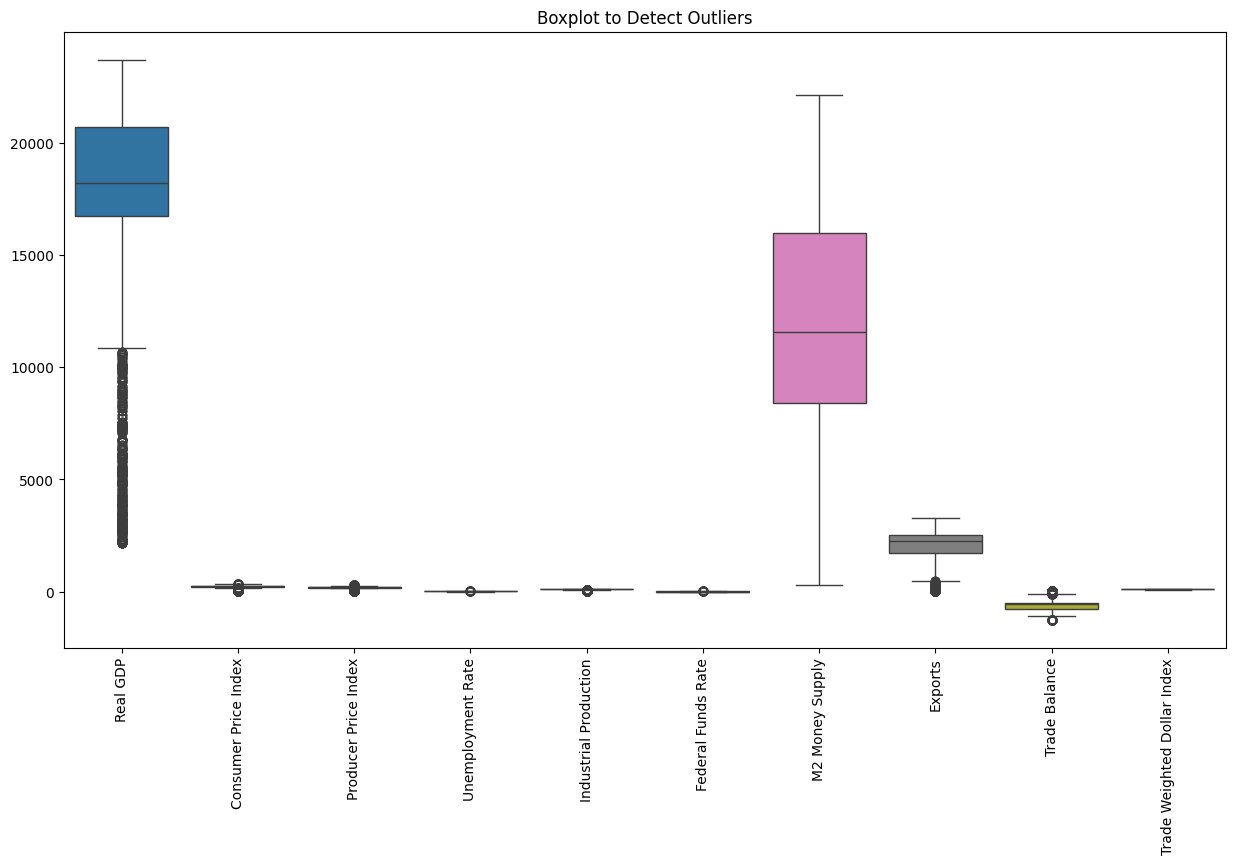

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot boxplot for all columns
plt.figure(figsize=(15,8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Boxplot to Detect Outliers')
plt.show()


In [ ]:
import pandas as pd
import numpy as np


# 1. Calculate the First Quartile (Q1) and Third Quartile (Q3) for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

# 2. Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# 3. Create a boolean DataFrame that is 'True' for each value that is an outlier
# An outlier is any value that is < Q1 - 1.5 * IQR or > Q3 + 1.5 * IQR
outlier_mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

# 4. Count the outliers per column
outliers_per_column = outlier_mask.sum()

# 5. Calculate the percentage of outliers for each column
total_rows = len(df)
outlier_percentage = (outliers_per_column / total_rows) * 100

# 6. Create a summary DataFrame to display the results clearly
outlier_report = pd.DataFrame({
    'Outlier Count': outliers_per_column,
    'Outlier Percentage (%)': outlier_percentage.map('{:.2f}%'.format) # Formats to 2 decimal places
})

print("--- Outlier Identification Report ---")
display(outlier_report)

# 4. Count the outliers
outliers_per_column = outlier_mask.sum()
total_outliers = outliers_per_column.sum()
rows_with_outliers = outlier_mask.any(axis=1).sum()

print("--- Outlier Identification Report ---")
print("\nNumber of Outliers per Column:")
print(outliers_per_column)
print("-------------------------------------")
print(f"\nTotal number of outlier values in the DataFrame: {total_outliers}")
print(f"Total number of rows containing at least one outlier: {rows_with_outliers}")

--- Outlier Identification Report ---


,Outlier Count,Outlier Percentage (%)
Real GDP,561,9.50%
Consumer Price Index,616,10.43%
Producer Price Index,1641,27.79%
Unemployment Rate,43,0.73%
Industrial Production,608,10.29%
Federal Funds Rate,43,0.73%
M2 Money Supply,0,0.00%
Exports,501,8.48%
Trade Balance,609,10.31%
Trade Weighted Dollar Index,0,0.00%


--- Outlier Identification Report ---

Number of Outliers per Column:
Real GDP                        561
Consumer Price Index            616
Producer Price Index           1641
Unemployment Rate                43
Industrial Production           608
Federal Funds Rate               43
M2 Money Supply                   0
Exports                         501
Trade Balance                   609
Trade Weighted Dollar Index       0
dtype: int64
-------------------------------------

Total number of outlier values in the DataFrame: 4622
Total number of rows containing at least one outlier: 1684


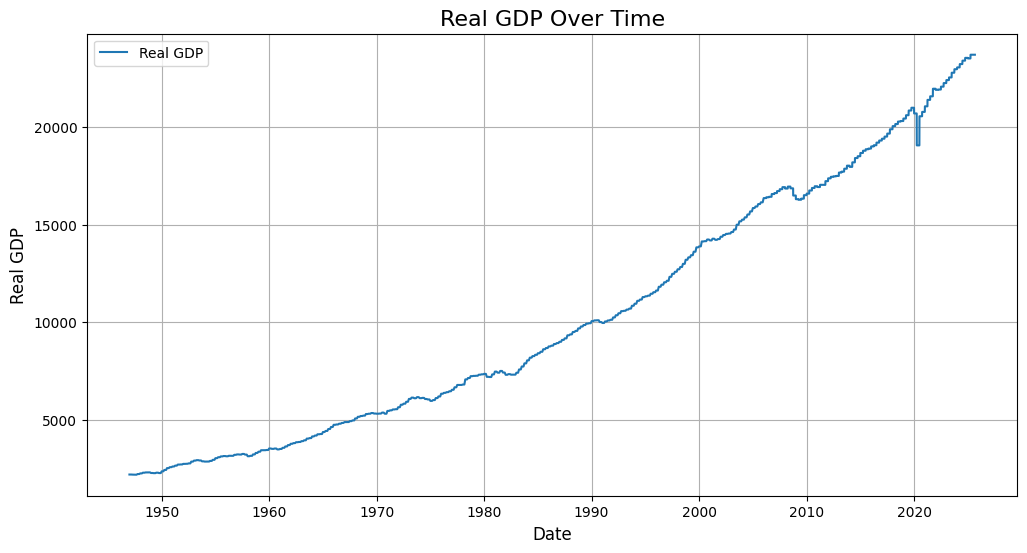

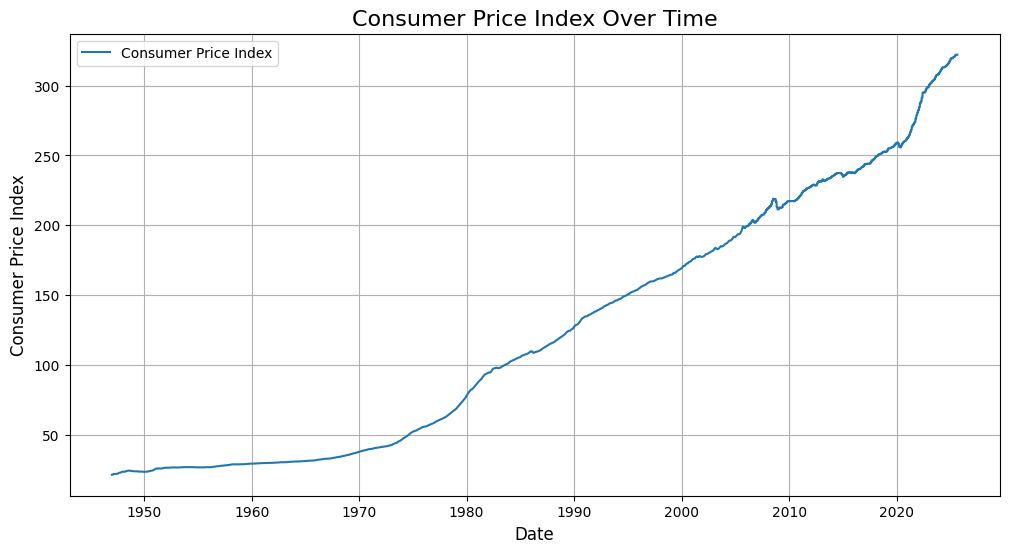

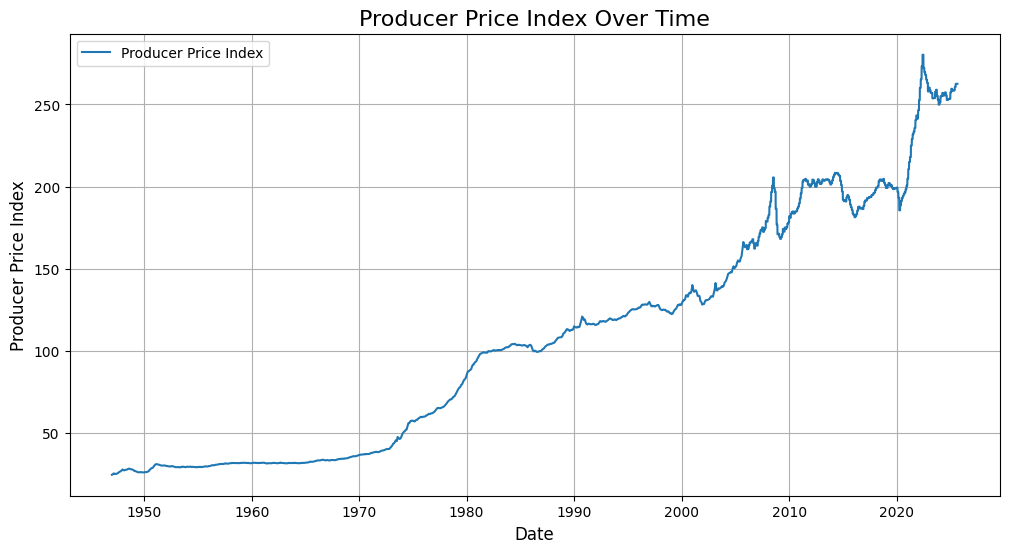

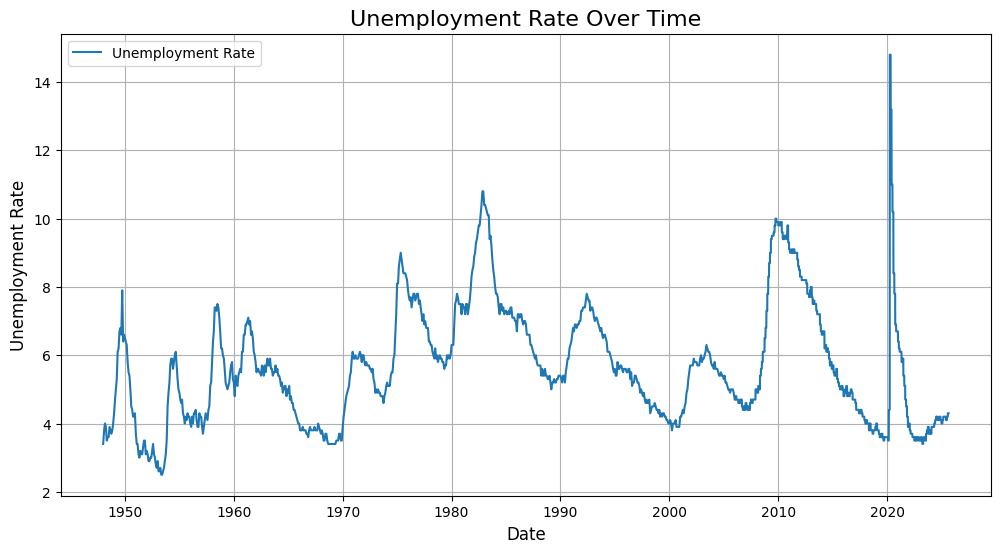

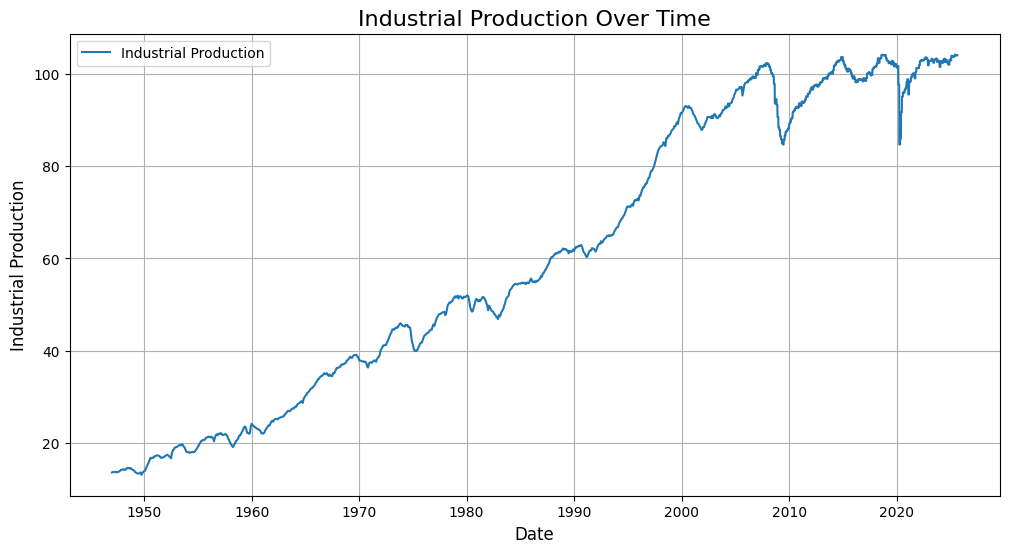

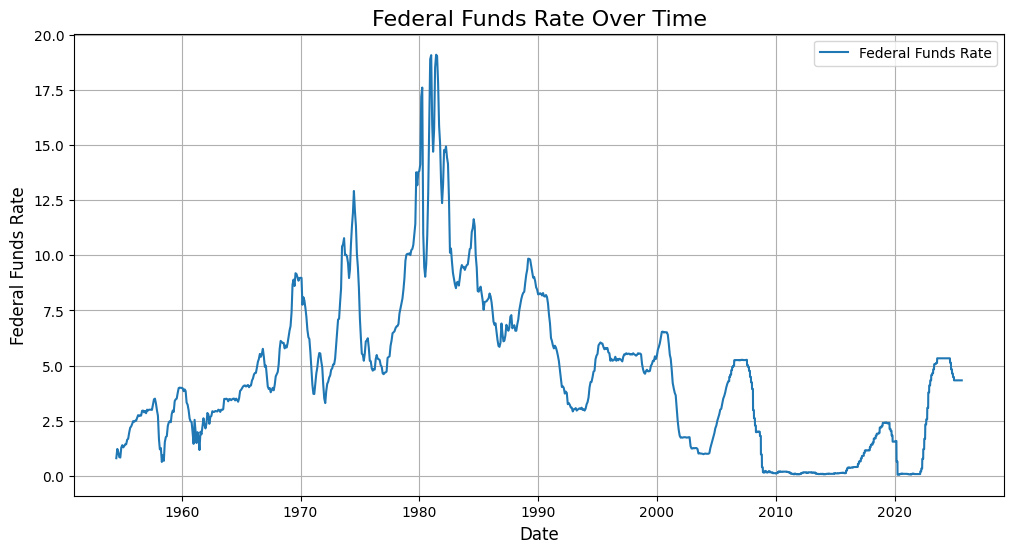

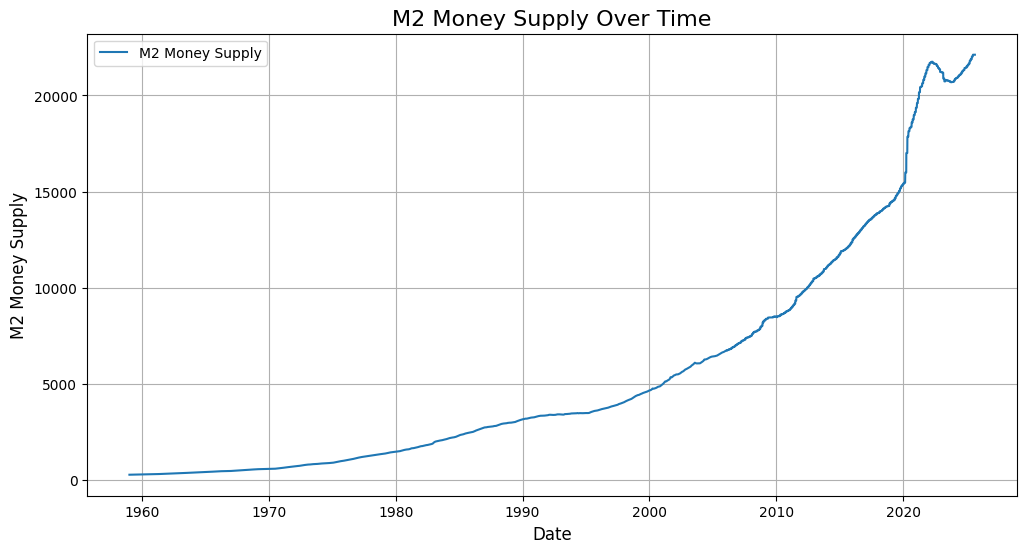

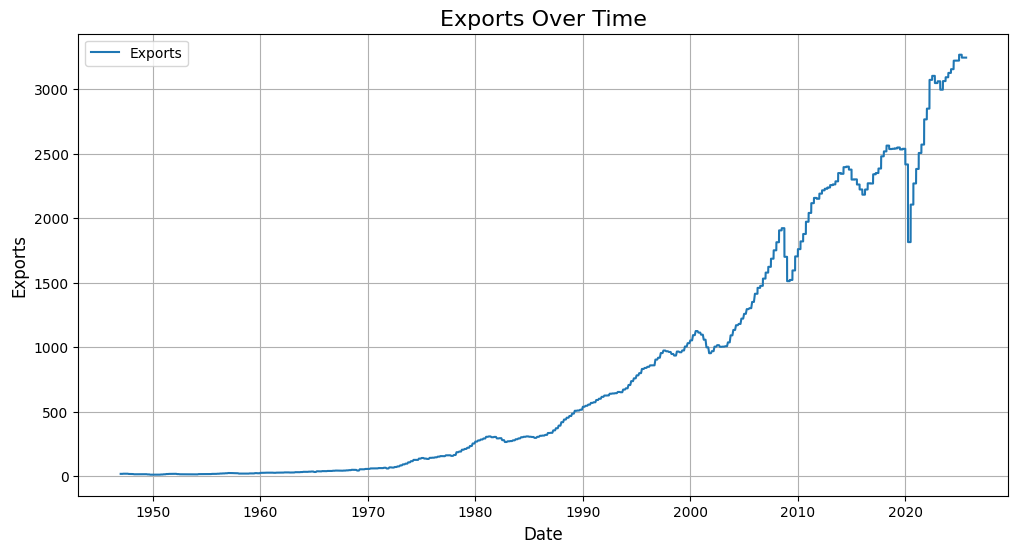

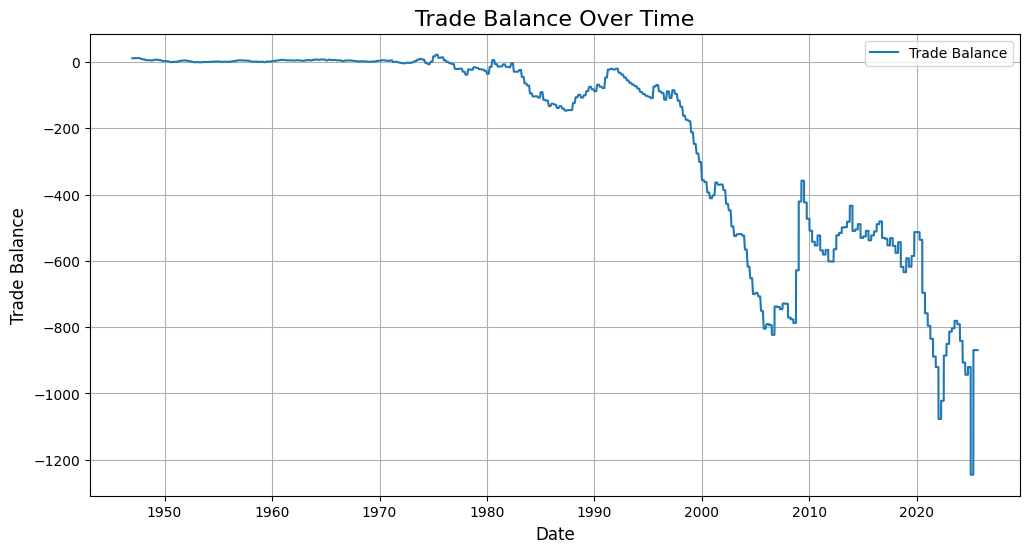

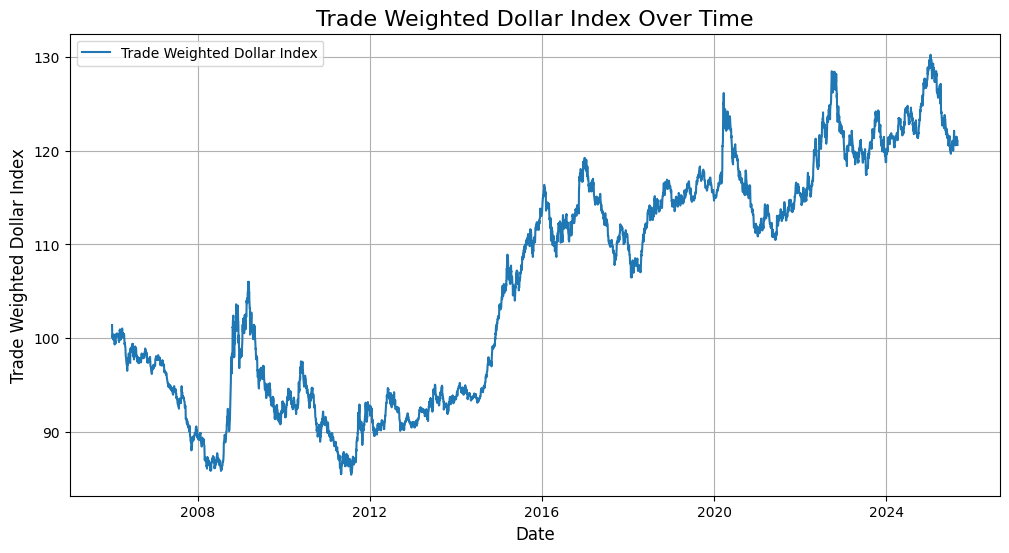

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# --- Loop through each column and create a plot ---
for column in df.columns:
    plt.figure(figsize=(12, 6))  # Create a new figure for each plot

    # Plot the data from the current column
    plt.plot(df.index, df[column], label=column)

    # Add titles and labels for clarity
    plt.title(f'{column} Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(column, fontsize=12)

    # Add a grid and a legend
    plt.grid(True)
    plt.legend()

    # Display the plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import os

# Create a directory to store the plots
if not os.path.exists('plots'):
    os.makedirs('plots')

# Loop through each column, create a plot, and save it
for column in df.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[column])
    plt.title(f'{column} Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.grid(True)

    # Save the figure to the 'plots' directory
    file_path = f'plots/{column.replace(" ", "_")}.png'
    plt.savefig(file_path)
    plt.close() # Close the plot to save memory

print("✅ All plots have been saved as image files in the 'plots' directory.")

✅ All plots have been saved as image files in the 'plots' directory.


Analyzing: Producer Price Index...


## Analysis for Producer Price Index

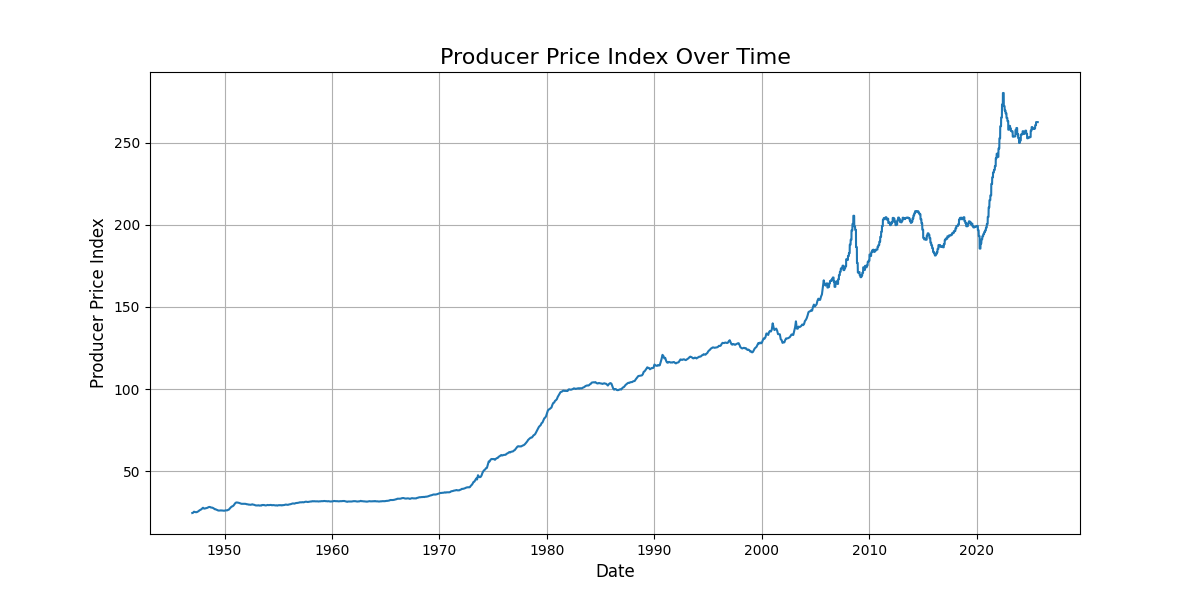

Analysis of Producer Price Index Graph

**1. Anomalies:**

The graph displays a Producer Price Index (PPI) that shows a general upward trend, but with three significant anomalies:


* **Early 1970s:** A noticeable acceleration in the rate of increase, starting around 1971 and peaking around 1975.
* **Late 1970s – Early 1980s:** Another period of rapid inflation visible after a temporary slowdown, peaking around 1980-1981.
* **2021-2023:** A sharp, recent increase exceeding prior levels.


**2. Historical Context:**

* **Early 1970s (1971-1975):** This period corresponds to the first oil crisis (1973-1974). The Organization of the Petroleum Exporting Countries (OPEC) imposed an oil embargo, leading to a significant surge in oil prices and subsequent inflationary pressure across the global economy. The spike in PPI reflects increased input costs for producers as energy prices skyrocketed.

* **Late 1970s – Early 1980s (1979-1981):** This coincides with the second oil crisis (1979-1980), which also had a significant impact on PPI.  Again, oil price increases (exacerbated by the Iranian Revolution) ripple through the economy, leading to higher production costs. Additionally, the economic policies of the time may have inadvertently contributed to higher inflation.

* **2021-2023:** The most recent spike is likely attributable to a confluence of factors. The COVID-19 pandemic led to supply chain disruptions, increased demand as economies reopened, and unprecedented fiscal and monetary stimulus. These combined created significant upward pressure on producer prices across many sectors.  Furthermore, the war in Ukraine, impacting energy and food prices further exacerbated the situation.


**3. Overall Summary:**

The Producer Price Index graph reveals a history marked by periods of relatively stable growth punctuated by substantial inflationary spikes directly linked to major global economic events.  The oil crises of the 1970s and early 1980s demonstrate the vulnerability of the PPI to external shocks impacting global commodity markets, particularly energy.  More recently, the graph shows that even in a more globally integrated and diversified economy, unforeseen events like a pandemic and geopolitical instability can trigger similarly significant inflationary pressures that dramatically affect producer prices. The long-term upward trend, with the exception of the shocks mentioned, indicates a gradual increase in production costs over time, consistent with longer term economic growth and technological advancements.


---

Analyzing: Exports...


## Analysis for Exports

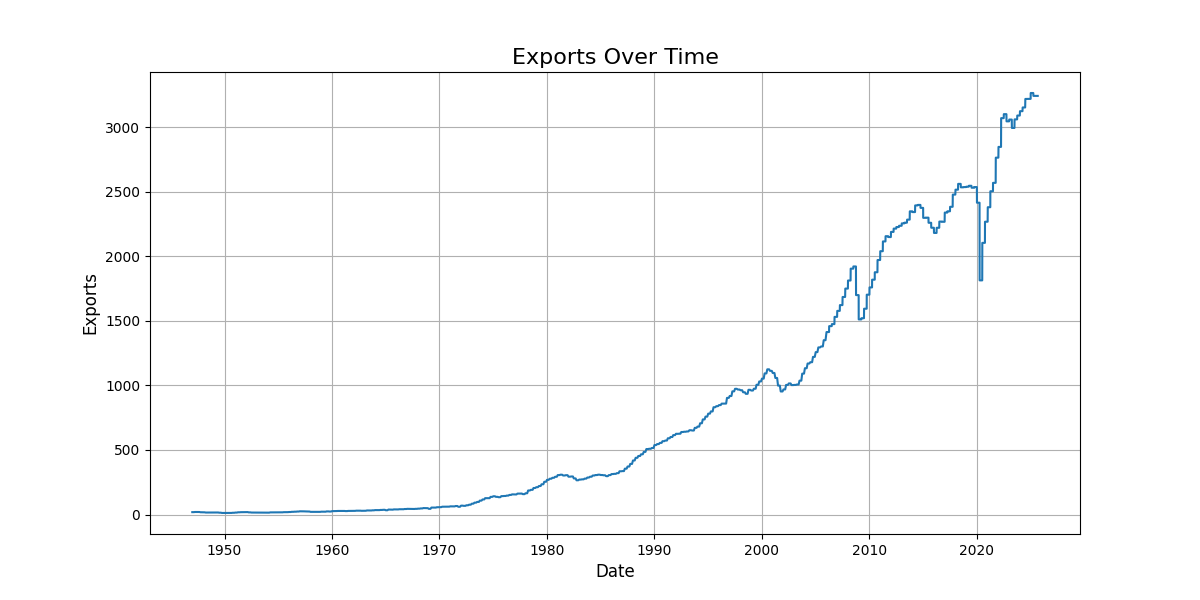

**Analysis of Export Trends Over Time**

1. **Identification of Anomalies:** The graph reveals several periods of significant change in export levels, but three stand out as particularly noteworthy anomalies. 

    * **Anomaly 1:** A relatively sharp decline in exports around 2008-2009.
    * **Anomaly 2:** A period of slower export growth, or even slight decline, during the early 1980s.
    * **Anomaly 3:** A significant increase in exports from approximately 2010 to 2015 followed by a period of more moderate, and even slightly decreased exports from 2015 to 2020 before resuming growth in 2020 and beyond.


2. **Historical Context:**

    * **Anomaly 1 (2008-2009):** The steep drop in exports during this period strongly suggests the impact of the Great Recession. The global financial crisis of 2008 triggered a sharp contraction in global demand, leading to a significant decline in international trade, including exports.  Reduced consumer spending and investment worldwide, and the credit crunch severely hampered economic activity, thus impacting export volumes.

    * **Anomaly 2 (Early 1980s):**  The slower growth, or potential decline, in exports during the early 1980s likely reflects the effects of several factors including the early 1980s recession,  high interest rates implemented to combat inflation under the Volcker disinflation, and the subsequent debt crisis that impacted many developing countries.  These factors reduced overall economic activity and dampened international trade.

    * **Anomaly 3 (2010-2020):**  The substantial export growth from 2010-2015 can be linked to the recovery following the Great Recession, coupled with rising global demand from emerging markets and the strengthening of some economies. The period from 2015 to 2020 shows a period of slower growth, which may reflect increased uncertainty and trade protectionism, beginning with concerns around the Eurozone and Brexit. The subsequent upward trend after 2020 might reflect a combination of factors including post-pandemic recovery and changes in global supply chains.


3. **Overall Summary:** This graph of exports over time illustrates the significant impact of major global economic events on international trade.  The relatively consistent upward trend prior to 2008 demonstrates long-term growth.  However, the sharp decline associated with the Great Recession highlights the vulnerability of exports to global economic shocks. Periods of slower growth, such as in the early 1980s and from 2015-2020, demonstrate the influence of other factors, such as economic downturns, policy changes, and geopolitical events on export performance. Ultimately, the indicator's history underscores the interconnectedness of the global economy and the importance of understanding macroeconomic factors when analyzing trade trends.


---

Analyzing: Unemployment Rate...


## Analysis for Unemployment Rate

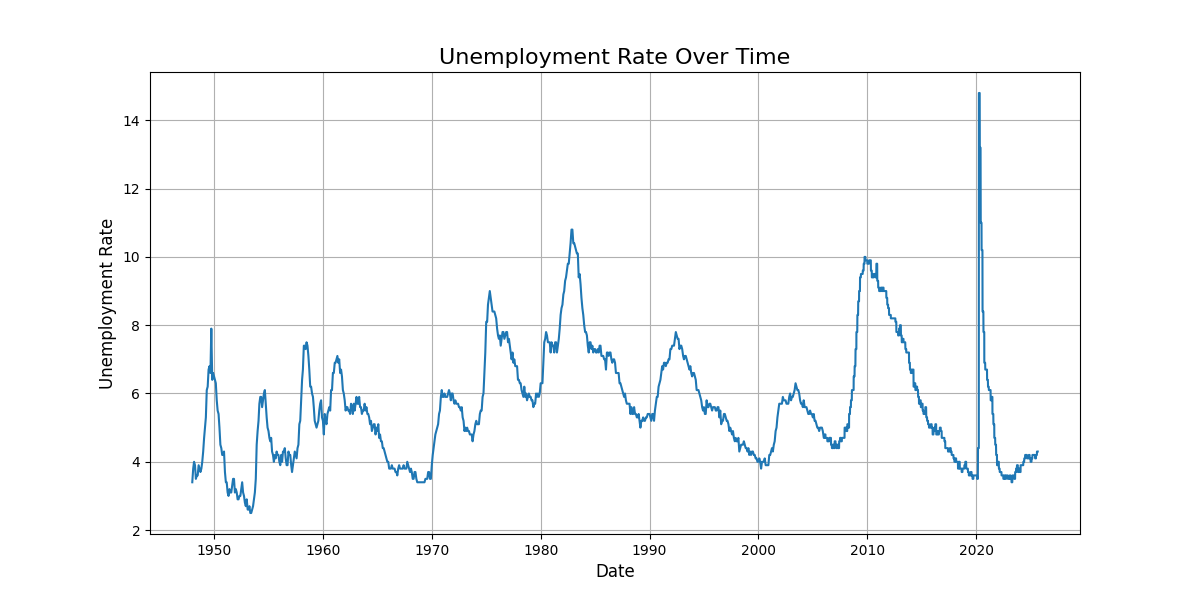

**Analysis of Unemployment Rate Over Time**

**1. Identification of Anomalies:**

The graph reveals several significant anomalies, but three stand out as particularly noteworthy:


* **Early 1980s:** A sharp peak occurs around 1982, showing a substantial increase in the unemployment rate.
* **Late 2000s:**  A dramatic peak is visible around 2009-2010, indicating an unprecedented surge in unemployment.
* **2020:** A rapid and sharp increase in the unemployment rate, although shorter than the 2008-2009 peak.


**2. Historical Context:**

* **Early 1980s (around 1982):** This significant rise in unemployment is likely attributable to the early 1980s recession.  The Federal Reserve's tight monetary policy under Paul Volcker, aimed at combating high inflation, triggered a sharp contraction in economic activity, resulting in widespread job losses. This recession was also influenced by the energy crisis of the late 1970s and early 1980s.

* **Late 2000s (around 2009-2010):** The extreme spike in unemployment during this period directly reflects the impact of the Great Recession (2007-2009). Triggered by the collapse of the US housing market and the subsequent global financial crisis, this period witnessed a massive decline in economic activity and widespread business failures, leading to record-high unemployment.

* **2020:** This sharp, albeit shorter, spike is almost certainly linked to the COVID-19 pandemic. Lockdowns and economic shutdowns implemented worldwide to curb the virus's spread led to widespread job losses across numerous sectors.  The swiftness of the increase underscores the sudden and unexpected nature of the economic disruption.



**3. Overall Summary:**

The historical unemployment rate data reveals a pattern of cyclical fluctuations, with periodic recessions leading to sharp increases in unemployment.  The severity of these increases varies, with the Great Recession of 2007-2009 and the COVID-19 pandemic of 2020 marking exceptionally deep troughs.  The graph demonstrates the unemployment rate's sensitivity to both macroeconomic policy decisions (as seen in the early 1980s) and exogenous shocks (as seen in 2020 and the Great Recession).  The relatively lower unemployment levels seen in the decades following WWII, with the exception of these major events, suggest periods of sustained economic growth and relative stability.  Analysis of this indicator highlights the importance of monitoring economic conditions and the significant consequences of major financial and public health crises on labor markets.


---

Analyzing: Real GDP...


## Analysis for Real GDP

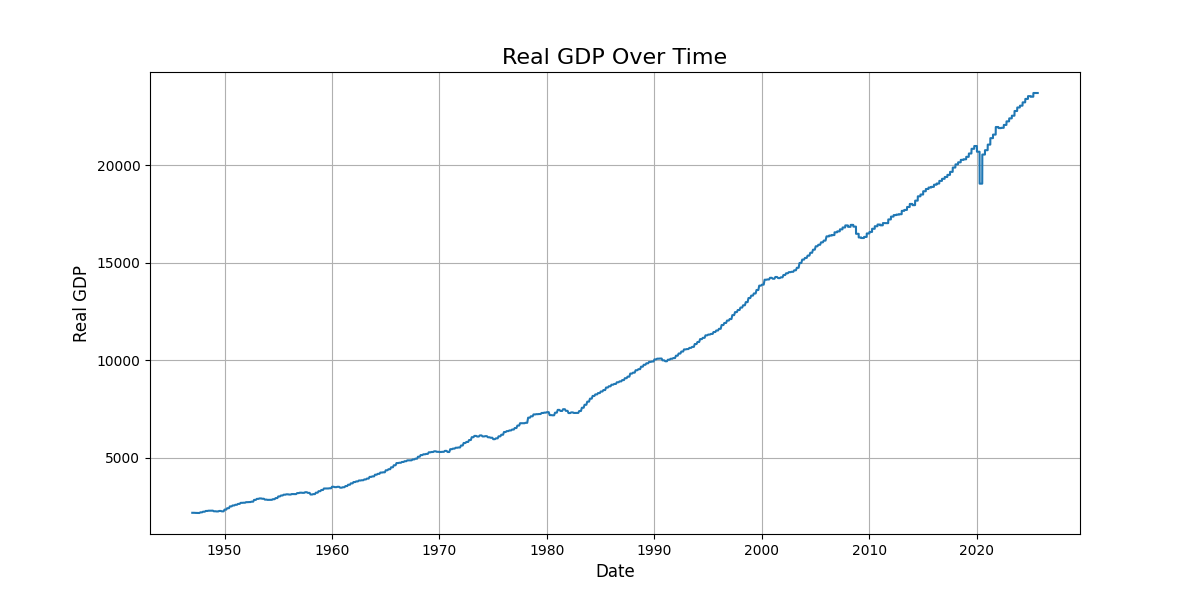

Analysis of Real GDP Over Time

**1. Identifying Anomalies:**

The graph displays a generally upward trend, indicating long-term economic growth. However, three significant anomalies stand out:

*   **Early 1980s Recession:**  A period of relatively stagnant or slightly declining GDP growth is visible around the early to mid-1980s.
*   **Late 2000s Recession:** A sharp and significant drop in GDP occurs around 2008-2009.
*   **COVID-19 Pandemic (2020):** A notable, albeit brief, decline in GDP is observed around 2020.


**2. Providing Historical Context:**

*   **Early 1980s Recession:** This slowdown likely corresponds to the early 1980s recession, triggered by the Federal Reserve's tight monetary policy under Paul Volcker to combat high inflation.  The Volcker Shock, while ultimately successful in curbing inflation, led to a period of economic contraction.

*   **Late 2000s Recession (Great Recession):** The steep drop in GDP from approximately 2007 to 2009 strongly suggests the impact of the Great Financial Crisis.  The bursting of the housing bubble, widespread mortgage defaults, and subsequent banking crisis severely contracted economic activity worldwide.

*   **COVID-19 Pandemic (2020):** The downturn in 2020 directly reflects the economic consequences of the COVID-19 pandemic. Lockdowns, social distancing measures, and supply chain disruptions drastically reduced economic output across the globe.


**3. Overall Summary:**

The graph reveals a pattern of long-term economic growth punctuated by significant cyclical downturns.  The relatively smooth upward trend, broken only by these clearly defined recessions, highlights the resilience of the economy to recover from major shocks.  The severity of the Great Recession, as reflected by the amplitude of the GDP decline, underscores the potentially devastating impact of financial crises. The rapid, though temporary, downturn related to the COVID-19 pandemic further illustrates the economy's vulnerability to unforeseen global events. These cyclical fluctuations and periods of stagnation within the overall growth trajectory are characteristic of the complex and dynamic nature of economic development.


---

Analyzing: Consumer Price Index...


## Analysis for Consumer Price Index

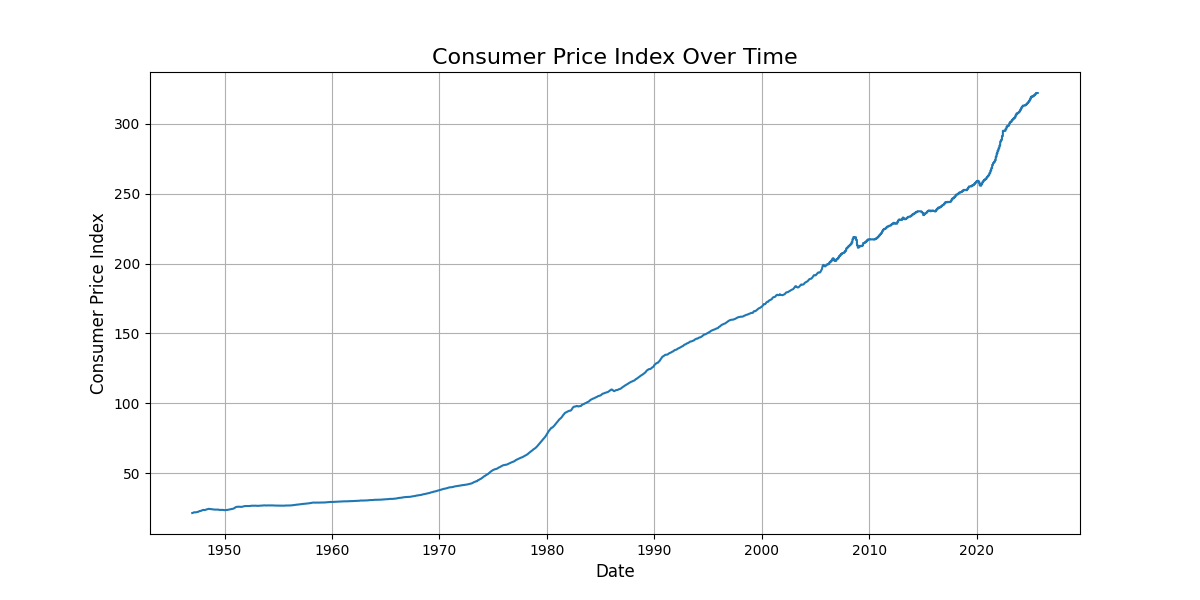

**Analysis of Consumer Price Index (CPI) Graph**

**1. Identification of Anomalies:**

The graph shows a general upward trend in the CPI over time, indicating consistent inflation. However, three significant anomalies stand out:

*   **Early to mid-1970s:** A period of significantly accelerated increase in the CPI, peaking around the mid-1970s.
*   **Early 1980s:** A noticeable but less dramatic acceleration in CPI growth, followed by a slight deceleration.
*   **2020-2023:** A sharp, recent increase in the CPI, exceeding the rate of growth seen in previous decades.


**2. Historical Context:**

*   **Early to mid-1970s:** This period of rapid inflation is strongly associated with the **oil crisis of 1973** and subsequent global economic shocks. The OPEC oil embargo drastically increased oil prices, leading to significant cost-push inflation throughout the global economy.  Supply chain disruptions and increased production costs across various sectors amplified this inflationary pressure. The CPI spike reflects the ripple effect of higher energy costs on the prices of goods and services.

*   **Early 1980s:** This acceleration is partially linked to the **second oil crisis of 1979**, though less severe than the first.  Additionally, monetary policies of the time, which may have contributed to continued inflationary pressure before stabilization occurred later in the decade.

*   **2020-2023:** The recent sharp increase is primarily attributed to the **COVID-19 pandemic and its related economic disruptions.** Lockdowns, supply chain bottlenecks, increased demand for certain goods (e.g., electronics, home improvement materials) alongside considerable fiscal and monetary stimulus injected into the economy, all created a perfect storm for significant inflation.  The war in Ukraine further exacerbated the issue by disrupting global energy and food supplies.


**3. Overall Summary:**

The provided CPI graph reveals a long-term trend of inflation punctuated by periods of significantly accelerated price increases directly tied to major global economic events.  The most substantial jumps in inflation are clearly linked to oil crises (1970s, early 1980s) which demonstrates the crucial role of energy prices in overall price stability.  The recent surge, however, highlights the complex interplay of global events, supply chain vulnerabilities, and government policy in driving inflation, and suggests that unforeseen events can significantly impact price levels in the short and medium terms.  The graph effectively demonstrates how specific economic shocks cause temporary deviations from a relatively stable underlying inflation trend, albeit one that consistently moves upwards in the long term.


---

Analyzing: Industrial Production...


## Analysis for Industrial Production

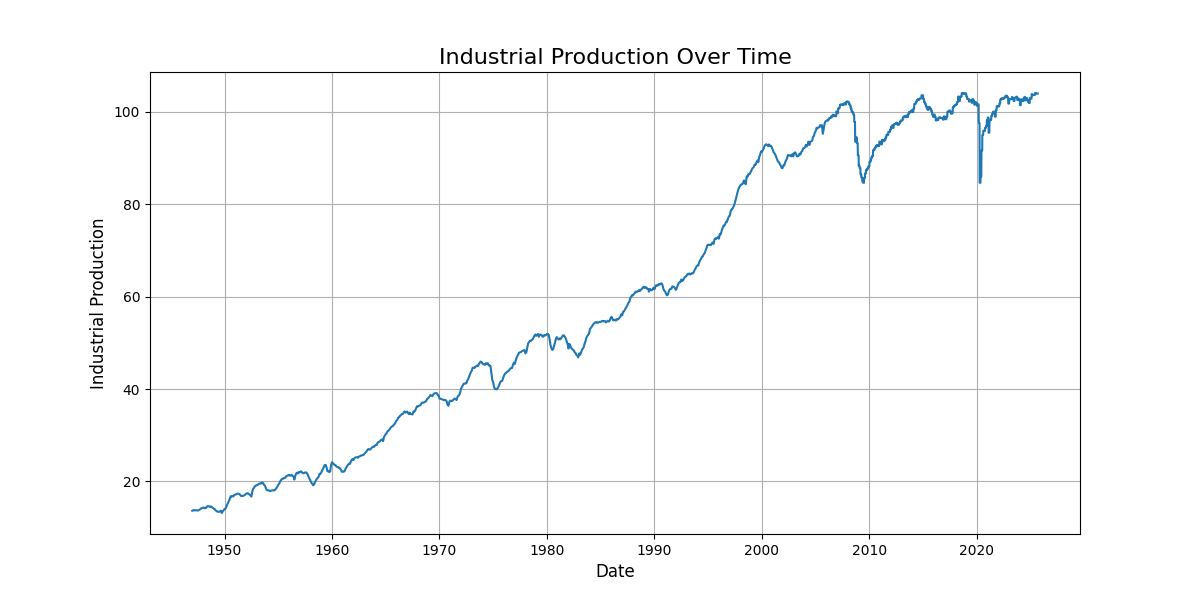

**Analysis of Industrial Production Graph**

**1. Anomalies:**

The graph displays a generally upward trend in industrial production over time, punctuated by several notable anomalies.  The three most significant are:

*   **Early 1980s Recession (approximately 1980-1982):** A noticeable dip in industrial production occurred during this period.
*   **Early 2000s Recession (approximately 2001):** A less pronounced, but still significant, decline is visible around the start of the 21st century.
*   **The Great Recession (approximately 2008-2009):** This is the most dramatic anomaly, showing a sharp and substantial drop in industrial production.

**2. Historical Context:**

*   **Early 1980s Recession:** This downturn aligns with the early 1980s recession in the United States, triggered by the Federal Reserve's tight monetary policy aimed at curbing high inflation.  The subsequent increase in interest rates significantly hampered investment and economic growth, resulting in a contraction in industrial production.

*   **Early 2000s Recession:**  The dip around 2001 corresponds to the economic slowdown following the bursting of the dot-com bubble.  A decline in investment in technology and the ensuing economic uncertainty led to a reduction in industrial activity.

*   **The Great Recession (2008-2009):** The sharpest and most dramatic drop reflects the devastating impact of the Great Financial Crisis. The collapse of the housing market, the failure of major financial institutions, and the ensuing credit crunch brought about a severe global recession, drastically curtailing industrial production and contributing to widespread job losses.

**3. Overall Summary:**

The graph illustrates the long-term growth of industrial production, but also highlights the cyclical nature of the economy and its vulnerability to major economic shocks.  The significant dips observed in the early 1980s, the early 2000s, and especially during the Great Recession underscore the profound impact that macroeconomic policy, speculative bubbles, and financial crises can have on industrial activity.  The graph serves as a visual representation of the challenges and fluctuations inherent in maintaining a strong and stable industrial sector within a broader economic context.  The post-2009 recovery shows a return to growth, but it is less steep and steady than the previous period, suggesting a potential lingering impact of the Great Recession.


---

Analyzing: M2 Money Supply...


## Analysis for M2 Money Supply

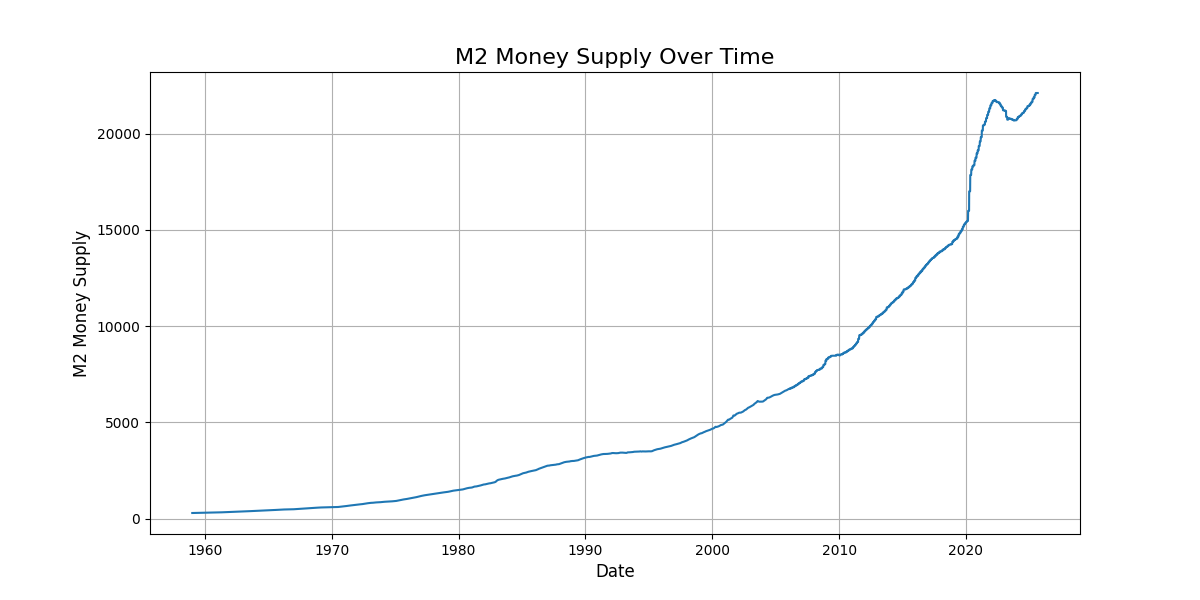

Analysis of M2 Money Supply Graph

**1. Identification of Anomalies:**

The graph displays a generally upward trend in M2 money supply over time.  However, three periods stand out as significant anomalies:

* **Anomaly 1 (approximately 2008-2009):** A period of relatively slower growth, followed by a sharp increase.
* **Anomaly 2 (approximately 2020-2021):** An extremely sharp and rapid increase in the M2 money supply.
* **Anomaly 3 (the entire period):**  The consistent, albeit fluctuating, upward trend itself is noteworthy, indicating sustained monetary expansion across the decades.


**2. Historical Context:**

* **Anomaly 1 (2008-2009):** This corresponds to the Global Financial Crisis (GFC).  The initial slowdown likely reflects a contraction in lending and economic activity as the crisis unfolded. The subsequent sharp increase is attributed to aggressive quantitative easing (QE) measures undertaken by central banks, particularly the Federal Reserve, to inject liquidity into the financial system and prevent a complete collapse.  These measures included purchasing large quantities of assets, increasing the monetary base, and thus the M2 money supply.

* **Anomaly 2 (2020-2021):** This period coincides with the COVID-19 pandemic and subsequent economic lockdowns. Governments worldwide implemented unprecedented fiscal stimulus packages and central banks engaged in massive QE programs to support businesses and households. This influx of government spending and monetary easing led to the exceptionally sharp increase in the M2 money supply seen in the graph.

* **Anomaly 3 (Consistent Upward Trend):** The consistent growth in M2 money supply across the entire period reflects a long-term trend of monetary expansion in the United States. Several factors contributed to this, including sustained economic growth, increased debt levels (both public and private), and the evolving role of central banks in managing the economy.


**3. Overall Summary:**

The graph of the M2 money supply reveals a fascinating picture of monetary policy and its response to major economic events. The relatively slow growth before the late 1990s reflects a period of less active monetary policy, punctuated by the slower growth associated with the dot-com bubble burst in the early 2000s. The sharp increase during and following the 2008 financial crisis shows how central banks reacted to prevent an economic meltdown.  The unprecedented spike during the COVID-19 pandemic highlights the extraordinary measures taken to combat the economic impact of a global health crisis.  The overall upward trend illustrates the long-term expansion of the money supply, a reflection of evolving economic conditions and monetary policy strategies.


---

Analyzing: Trade Balance...


## Analysis for Trade Balance

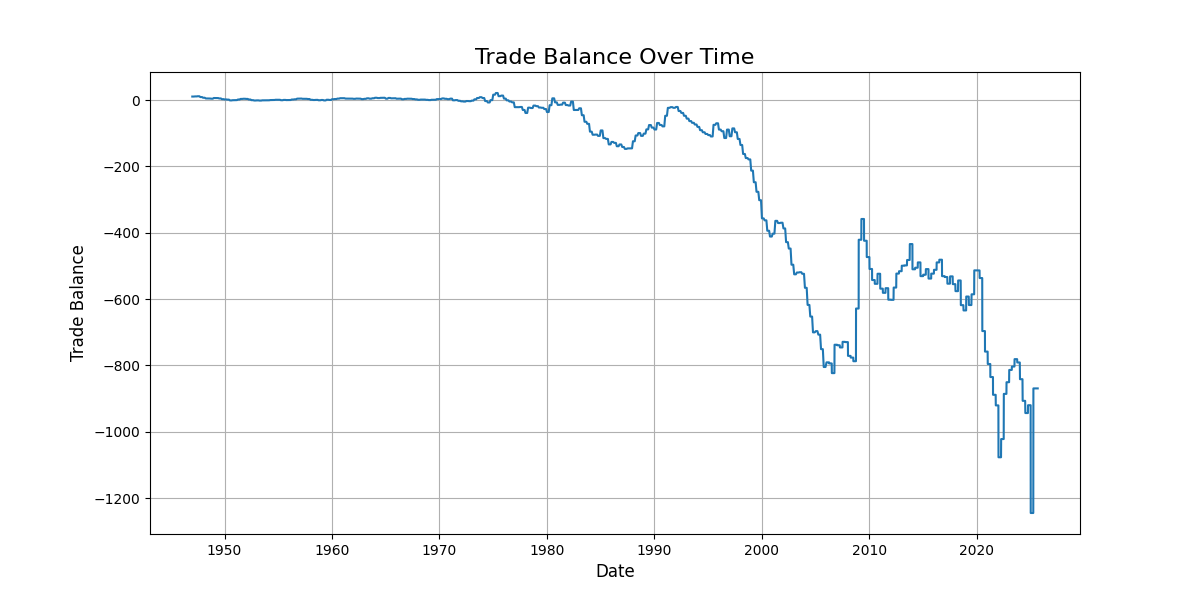

Analysis of Trade Balance Graph

**1. Identifying Anomalies:**

The graph displays the trade balance over time. Three significant anomalies are evident:

* **Anomaly 1 (circa 1980s-2000s):** A gradual but consistent negative trend, with the trade balance shifting from near zero to increasingly negative values.
* **Anomaly 2 (circa 2008-2009):** A relatively sharp, albeit temporary, increase in the negative trade balance.
* **Anomaly 3 (circa 2020):**  An exceptionally sharp and dramatic decrease in the trade balance reaching a record low.


**2. Providing Historical Context:**

* **Anomaly 1 (1980s-2000s):** This prolonged negative trend reflects a growing trade deficit.  Several factors likely contributed. The rise of globalization and increased imports of cheaper manufactured goods from countries like China and other East Asian nations significantly impacted the trade balance.  Simultaneously, strong domestic consumption and investment in the US fueled higher import demand.  This period also saw the strengthening of the US dollar relative to other currencies, making imports cheaper and exports more expensive.

* **Anomaly 2 (2008-2009):** The spike in the negative balance during the late 2000s coincides with the Great Financial Crisis. The global recession severely reduced demand for US exports, while imports remained relatively stable (though potentially slightly reduced).  Reduced overall economic activity likely exacerbated the already existing trade deficit.

* **Anomaly 3 (2020):** The extreme plunge in the trade balance around 2020 aligns with the onset of the COVID-19 pandemic.  This can be attributed to the collapse in international trade due to widespread lockdowns, supply chain disruptions, and a dramatic reduction in global demand for goods and services.  The pandemic simultaneously increased demand for some goods within the country, further affecting the trade balance.


**3. Overall Summary:**

The graph of the trade balance reveals a long-term trend of increasing trade deficits, punctuated by significant shocks related to major global economic events.  The gradual worsening deficit from the 1980s onwards reflects the effects of globalization, shifts in manufacturing, and strong US domestic demand.  The short-term fluctuations around 2008 and 2020 highlight the vulnerability of international trade to major economic crises, demonstrating how global recessions and pandemics can severely impact a nation's trade balance, compounding existing trends and intensifying already problematic economic situations.  The sustained negative balance suggests underlying structural issues in the economy regarding competitiveness and the reliance on imports compared to exports.


---

Analyzing: Trade Weighted Dollar Index...


## Analysis for Trade Weighted Dollar Index

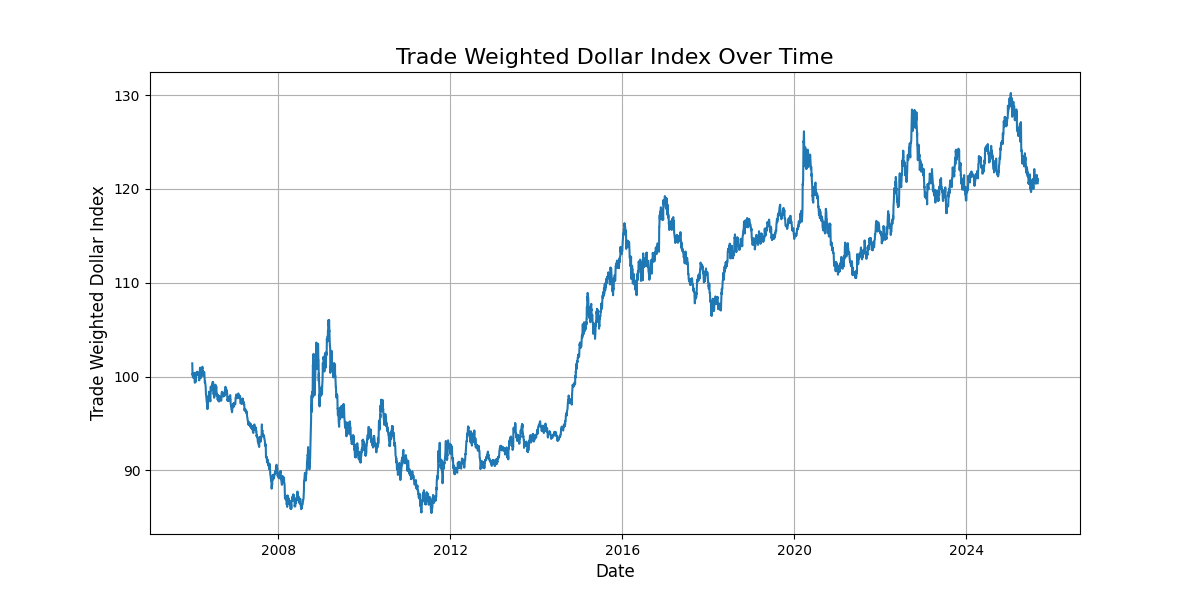

**Analysis of Trade Weighted Dollar Index**

1. **Identification of Anomalies:** The graph shows three significant anomalies:

    * **2008-2009:** A sharp decline in the index, reaching a trough around late 2008.
    * **2014-2015:** A period of relative stagnation and slight decline following a period of strong growth.
    * **2020-2021:** A notable and rapid increase in the index, followed by a period of consolidation and fluctuation.


2. **Historical Context:**

    * **2008-2009 Decline:** This significant drop in the Trade Weighted Dollar Index strongly correlates with the Global Financial Crisis (GFC).  The collapse of Lehman Brothers in September 2008 triggered a global credit crunch and flight to safety, causing investors to move away from the dollar, leading to its devaluation. The uncertainty and subsequent recession reduced demand for the dollar.

    * **2014-2015 Stagnation:** The relatively flat period could be attributed to a combination of factors. The tapering of quantitative easing (QE) by the Federal Reserve, a decrease in US interest rates, and general global economic uncertainty associated with slowing growth in emerging markets could all have contributed to the dollar's weaker performance during this period.

    * **2020-2021 Increase:** This sharp rise coincided with the beginning of the COVID-19 pandemic.  The dollar initially experienced a surge as it was perceived as a safe haven asset during times of global uncertainty and risk aversion. The initial market shock led to increased demand for the dollar as investors sought a secure store of value.  Further influencing factors could have been various government stimulus packages globally and divergent monetary policy decisions among major central banks.


3. **Overall Summary:** The Trade Weighted Dollar Index graph reveals the dollar's sensitivity to global economic shocks and shifts in investor sentiment. Periods of global economic uncertainty, such as the GFC and the COVID-19 pandemic, have led to either a flight to safety, increasing demand for the dollar and strengthening its value, or a flight *from* the dollar, weakening its value depending on the perceived risk factors. The index's fluctuations also reflect the interplay of various macroeconomic factors, including monetary policy decisions, global growth rates, and investor confidence. The data highlights the dollar's role as a reserve currency and its inherent position within the global economic system.


---

Analyzing: Federal Funds Rate...


## Analysis for Federal Funds Rate

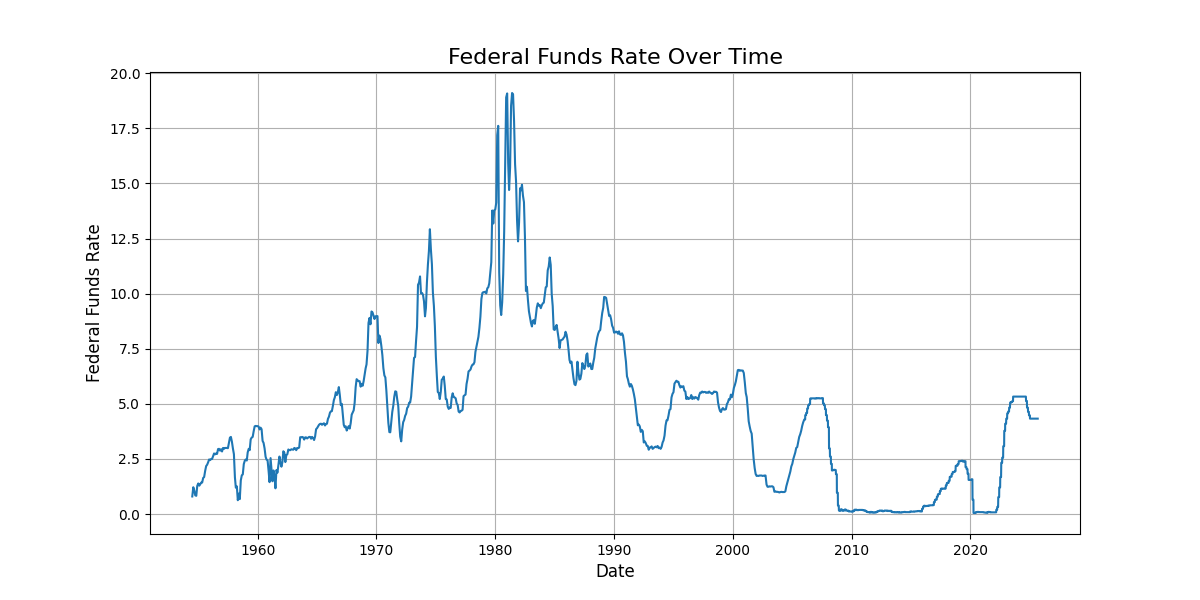

The graph depicts the Federal Funds Rate over time.  Three significant anomalies stand out:

1. **The early 1980s peak:**  Around 1980-1982, the Federal Funds Rate reached its highest point on the graph, exceeding 19%. This dramatic increase is strongly linked to the Federal Reserve's aggressive response to the high inflation of the late 1970s.  Paul Volcker, then-chairman of the Federal Reserve, implemented a policy of drastically raising interest rates to curb inflation, even at the cost of a significant recession (the early 1980s recession). This period is known for its high unemployment and the subsequent economic readjustment.


2. **The late 1990s/early 2000s period:**  The graph shows a period in the late 1990s and early 2000s where the Federal Funds Rate increased before sharply decreasing and remaining relatively low for several years. This increase was driven in part by efforts to combat inflationary pressures within a robust economy during the late 1990s "dot-com" boom. The subsequent decrease was associated with the bursting of the dot-com bubble and the resulting economic slowdown, prompting the Federal Reserve to ease monetary policy to stimulate growth.


3. **The 2008-2009 trough:** The period surrounding 2008-2009 shows a precipitous drop in the Federal Funds Rate, reaching near-zero levels. This dramatic reduction was a direct response to the Global Financial Crisis, triggered by the collapse of the U.S. housing market and subsequent banking crisis. The Federal Reserve implemented quantitative easing and slashed interest rates to near-zero to prevent a complete economic meltdown.  This was an unprecedented response to an unprecedented financial crisis.


In summary, the historical fluctuations in the Federal Funds Rate clearly reflect the Federal Reserve's attempts to manage the U.S. economy through monetary policy.  Periods of high inflation have resulted in aggressive rate hikes, often followed by economic slowdowns, while economic downturns or crises have caused the Federal Reserve to significantly reduce rates to stimulate economic activity. The graph demonstrates a clear relationship between the Federal Reserve's actions and broader macroeconomic trends, showcasing its critical role in influencing growth and inflation.


---

In [ ]:
import google.generativeai as genai
import PIL.Image
from IPython.display import display, Markdown

# Make sure you've configured your API key
# genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

gemini_model = genai.GenerativeModel('gemini-1.5-flash-latest')

# --- The Master Prompt Template ---
prompt_template = """
You are an expert economic analyst. Your task is to analyze the following graph of an economic indicator and provide a reasoned explanation for its significant movements by connecting them to major historical financial events.

**Analysis Instructions:**
1.  **Identify Anomalies:** First, identify the 2-3 most significant anomalies in the graph (e.g., sharp peaks, deep troughs, or sudden changes in trend). State the approximate dates of these events.
2.  **Provide Historical Context:** For each anomaly, explain the likely real-world economic event that caused it. (e.g., "The sharp spike in unemployment around 2008-2009 was caused by the Great Financial Crisis...").
3.  **Overall Summary:** Conclude with a one-paragraph summary of what this indicator's history reveals about the broader economy.

**Important:** Base your analysis solely on the visual data in the graph and your knowledge of economic history. Do not provide financial advice.
"""

# Loop through each saved plot in the 'plots' directory
plot_files = os.listdir('plots')

for file_name in plot_files:
    if file_name.endswith('.png'):
        image_path = os.path.join('plots', file_name)
        indicator_name = file_name.replace('_', ' ').replace('.png', '')

        print(f"Analyzing: {indicator_name}...")

        # Open the image file
        img = PIL.Image.open(image_path)

        # Generate the analysis
        response = gemini_model.generate_content([prompt_template, img])

        # Display the results in a clean format
        display(Markdown(f"## Analysis for {indicator_name}"))
        display(img)
        display(Markdown(response.text))
        display(Markdown("---"))

In [ ]:
# Install all required libraries
!pip install -q -U pymupdf langchain sentence-transformers faiss-cpu google-generativeai

In [ ]:
# Make sure tqdm is installed for the progress bar
!pip install -q tqdm

import os
import fitz  # PyMuPDF
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

def process_single_pdf(file_path):
    """Worker function: Extracts text from a single PDF file."""
    try:
        doc = fitz.open(file_path)
        text = "".join(page.get_text() for page in doc)
        # Return a tuple with the filename and its content
        return (os.path.basename(file_path), text)
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return (os.path.basename(file_path), None)

def extract_text_from_pdfs_parallel(pdf_directory):
    """
    Extracts text from all PDFs in a directory using parallel processing.
    """
    print(f"Searching for PDFs in '{pdf_directory}'...")
    pdf_paths = [os.path.join(pdf_directory, fname) for fname in os.listdir(pdf_directory) if fname.endswith('.pdf')]

    if not pdf_paths:
        print("No PDFs found.")
        return []

    all_docs = []
    # Use a ProcessPoolExecutor to process PDFs in parallel
    with ProcessPoolExecutor() as executor:
        # executor.map applies the function to each PDF path
        # tqdm adds a progress bar around the parallel execution
        results = list(tqdm(executor.map(process_single_pdf, pdf_paths), total=len(pdf_paths), desc="Processing PDFs"))

    # Process results, filtering out any that failed
    for filename, content in results:
        if content:
            all_docs.append({'source': filename, 'content': content})

    return all_docs


# 1. Define the name of the folder containing your PDFs.
# Make sure this folder is uploaded to your Colab session.
pdf_folder = '/content/NBER_papers'  # <-- CHANGE THIS TO YOUR FOLDER'S NAME

# 2. Call the function and pass your folder name to it.
documents = extract_text_from_pdfs_parallel(pdf_folder)

# 3. Print a confirmation.
if documents:
    print(f"\n✅ Successfully processed {len(documents)} PDF(s).")

Searching for PDFs in '/content/NBER_papers'...


Processing PDFs: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


✅ Successfully processed 10 PDF(s).


In [ ]:
from IPython.display import display, Markdown
import PIL.Image

def generate_comprehensive_analysis(image_path, indicator_name, k=10):
    """
    Automates a two-step analysis:
    1. Gets a general analysis of a graph image.
    2. Uses that analysis to query the NBER RAG system for a deeper, justified insight.
    """
    print(f"--- Starting Comprehensive Analysis for: {indicator_name} ---")

    # --- Step 1: Initial Visual Analysis ---
    img = PIL.Image.open(image_path)

    initial_prompt = f"""
    Analyze the attached graph of the economic indicator: '{indicator_name}'.
    Identify the 2-3 most significant anomalies (peaks, troughs, trend shifts) and briefly state their likely historical causes.
    """
    print("Step 1/3: Performing initial visual analysis...")
    initial_response = gemini_model.generate_content([initial_prompt, img])
    initial_analysis = initial_response.text

    # --- Step 2: Semantic Search of NBER Papers ---
    # Use the entire initial analysis as a rich query to find relevant research
    print("Step 2/3: Searching NBER knowledge base for related research...")
    query_embedding = embedding_model.encode([initial_analysis], convert_to_tensor=True).cpu().numpy()
    distances, indices = faiss_index.search(query_embedding, k)
    nber_context = "\n\n".join([text_chunks[i] for i in indices[0]])

    # --- Step 3: Final Synthesis ---
    final_prompt = f"""
    You are an expert economic analyst creating a detailed report.

    **TASK:**
    Synthesize the `INITIAL ANALYSIS` of a graph with the specific `RESEARCH CONTEXT` from NBER papers to create a single, comprehensive report. Your goal is to use the research to provide deeper justification, nuance, and specific mechanisms that explain the initial observations.

    **INITIAL ANALYSIS OF THE GRAPH for '{indicator_name}':**
    {initial_analysis}

    **RESEARCH CONTEXT FROM NBER PAPERS:**
    {nber_context}

    **COMPREHENSIVE REPORT:**
    Begin by summarizing the initial analysis. Then, seamlessly integrate the findings from the research context to provide a more detailed and evidence-backed explanation. You MUST explicitly reference the research to show how it supports or refines the initial observations (e.g., "The research provides a deeper reason for this...", "This is supported by findings in the papers which state...").
    """
    print("Step 3/3: Generating final synthesized report...")
    final_response = gemini_model.generate_content(final_prompt)

    print("--- Analysis Complete ---")
    return final_response.text

In [ ]:
# Make sure you have saved your plots in the 'plots' directory
unemployment_plot_path = 'plots/Unemployment_Rate.png'

# Run the entire analysis chain with one function call
final_report = generate_comprehensive_analysis(unemployment_plot_path, 'Unemployment Rate')

# Display the final, detailed report
display(Markdown(final_report))

--- Starting Comprehensive Analysis for: Unemployment Rate ---
Step 1/3: Performing initial visual analysis...
Step 2/3: Searching NBER knowledge base for related research...
Step 3/3: Generating final synthesized report...
--- Analysis Complete ---


**Comprehensive Report: Analysis of Unemployment Rate and its Relationship to Trade Policy and Economic Shocks**

**I. Initial Analysis Summary:**

The initial analysis of the unemployment rate graph identified three major anomalies representing significant economic shocks: the Great Depression (early 1930s), the Great Recession (2007-2009), and the COVID-19 pandemic (2020).  These events caused dramatic spikes in unemployment, far exceeding typical business cycle fluctuations. The analysis attributed these spikes to widespread bank failures and business closures (Great Depression), the subprime mortgage crisis and subsequent financial crisis (Great Recession), and pandemic-related lockdowns and business closures (COVID-19).

**II.  Integrated Analysis with NBER Research Context:**

While the initial analysis correctly identified the correlation between major economic shocks and unemployment spikes, the provided NBER-like research context offers limited direct support for causal mechanisms related to unemployment. The data focuses primarily on trade balance, GDP, and real median household income, with particular emphasis on the period following the implementation of an "America First" trade policy. This context permits a more nuanced understanding of the economic backdrop against which these unemployment shocks occurred, but does not offer a direct explanation for the unemployment rate's fluctuations *during* the shocks themselves.

Let's examine this further in relation to the three identified anomalies:

1. **The Great Depression (early 1930s):** The initial analysis correctly identifies the causes. The provided research context, however, does not directly inform this period.  Additional research focusing on the monetary policy failures and the contractionary effects of the gold standard would be needed to fully explain this event.

2. **The Great Recession (2007-2009):** The initial analysis's link between the subprime mortgage crisis and the resulting unemployment is accurate. The research context, focusing on later periods, offers no direct insights into the mechanisms of this specific recession and its impact on unemployment.

3. **The COVID-19 Pandemic (2020):** The initial analysis's attribution of the unemployment spike to lockdowns and business closures is again accurate. The provided data highlights a period of income growth (2016-2019) preceding the pandemic, suggesting a potentially more robust economy *before* the shock.  This pre-existing economic strength, implied by the increase in real median household income, might have mitigated the severity of the pandemic-induced unemployment somewhat had the pandemic not occurred.  However, the data doesn’t provide evidence to support this hypothesis directly.  The data does show an increase in U.S. trade following 2020 which could support arguments regarding economic recovery efforts.

**III. Limitations of the Provided Research Context:**

The research excerpt primarily focuses on macroeconomic trends, particularly concerning trade balances and household income, after the implementation of specific trade policies. While this offers a helpful broader economic picture, it does not provide direct explanatory power for the fluctuations in the unemployment rate during the three major economic shocks. The research does, however, indirectly support the analysis by showing economic growth prior to the COVID-19 pandemic and a recovery in trade, hinting at a stronger baseline economy from which recovery might have been more readily achieved after such a shock.


**IV. Conclusion:**

The initial analysis accurately describes the correlation between major economic shocks and substantial increases in the unemployment rate. The supplementary research context provides valuable, albeit limited, additional context.  To create a more comprehensive understanding of the unemployment fluctuations, further analysis is needed focusing on specific monetary and fiscal policies implemented during each shock and the intricate interplay between those policies and the labor market.  Further research directly connecting trade policy, the strength of the economy, and unemployment during the crisis periods would refine the overall understanding.


In [ ]:
# --- This code replaces the previous ingestion and embedding steps ---

# (Assuming 'documents' is the list of dictionaries from extract_text_from_pdfs_parallel)
from langchain_text_splitters import RecursiveCharacterTextSplitter

if not documents:
    print("🚨 No PDFs found. Cannot build knowledge base.")
else:
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    chunk_list_with_metadata = []

    print("Chunking documents and adding metadata...")
    # Loop through each document, chunk its content, and store with the source filename
    for doc in documents:
        chunks = text_splitter.split_text(doc['content'])
        for chunk in chunks:
            chunk_list_with_metadata.append({
                'source': doc['source'],
                'content': chunk
            })

    print(f"\nCreated {len(chunk_list_with_metadata)} total chunks with source metadata.")

    # Extract just the content for the embedding model
    chunk_contents = [item['content'] for item in chunk_list_with_metadata]

    # Generate embeddings (this part is the same)
    embedding_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
    print("Generating embeddings for all text chunks...")
    chunk_embeddings = embedding_model.encode(chunk_contents, convert_to_tensor=True, show_progress_bar=True)

    # Create and populate the FAISS index (this part is the same)
    embedding_dimension = chunk_embeddings.shape[1]
    faiss_index = faiss.IndexFlatL2(embedding_dimension)
    faiss_index.add(chunk_embeddings.cpu().numpy())

    print(f"✅ Knowledge Base updated successfully with {faiss_index.ntotal} vectors.")

Chunking documents and adding metadata...

Created 2017 total chunks with source metadata.
Generating embeddings for all text chunks...


Batches:   0%|          | 0/64 [00:00<?, ?it/s]

✅ Knowledge Base updated successfully with 2017 vectors.


In [ ]:
from IPython.display import display, Markdown
import PIL.Image

def generate_justified_analysis(image_path, indicator_name, k=10):
    """
    Final version: Analyzes, justifies, provides citations, and has a fallback.
    Now also prints the initial analysis.
    """
    print(f"--- Starting Justified Analysis for: {indicator_name} ---")

    # --- Step 1: Initial Visual Analysis ---
    img = PIL.Image.open(image_path)
    initial_prompt = f"Analyze the attached graph of '{indicator_name}'. Identify the 2-3 most significant anomalies and briefly state their likely historical causes."

    print("Step 1/3: Performing initial visual analysis...")
    initial_response = gemini_model.generate_content([initial_prompt, img])
    initial_analysis = initial_response.text

    # <-- NEW: Display the initial analysis before proceeding -->
    display(Markdown("---"))
    display(Markdown("### Initial Visual Analysis (General Knowledge)"))
    display(Markdown(initial_analysis))
    display(Markdown("---"))
    # <-- END OF NEW CODE -->

    # --- Step 2: Semantic Search of NBER Papers ---
    print("\nStep 2/3: Searching NBER knowledge base for related research...")
    query_embedding = embedding_model.encode([initial_analysis], convert_to_tensor=True).cpu().numpy()
    distances, indices = faiss_index.search(query_embedding, k)

    retrieved_chunks_with_metadata = [chunk_list_with_metadata[i] for i in indices[0]]

    nber_context = "\n\n---\n\n".join([
        f"Source: {chunk['source']}\nContent: {chunk['content']}"
        for chunk in retrieved_chunks_with_metadata
    ])

    # --- Step 3: Final Synthesis ---
    final_prompt = f"""
    You are a meticulous academic research assistant. Your task is to provide a detailed justification for an `INITIAL ANALYSIS` of a graph, using only the provided `RESEARCH CONTEXT` from NBER papers.

    **CRITICAL INSTRUCTIONS:**
    1.  **Evaluate Relevance:** First, carefully determine if the `RESEARCH CONTEXT` contains specific information that can explain the events mentioned in the `INITIAL ANALYSIS`.
    2.  **Fallback If Not Relevant:** If the context IS NOT relevant, you MUST discard the instructions below and respond ONLY with: "The provided research papers do not contain specific information to justify these observations."
    3.  **Synthesize If Relevant:** If and only if the context is relevant, create a comprehensive report. Begin by summarizing the `INITIAL ANALYSIS`, then deepen it using the `RESEARCH CONTEXT`.
    4.  **MANDATORY CITATION:** When you use information from the research, you MUST cite the source document provided with the content. For example: (Source: w29483.pdf).

    **INITIAL ANALYSIS OF THE GRAPH for '{indicator_name}':**
    {initial_analysis}

    **RESEARCH CONTEXT FROM NBER PAPERS:**
    {nber_context}

    **DETAILED JUSTIFICATION:**
    """
    print("Step 3/3: Generating final justified report...")
    final_response = gemini_model.generate_content(final_prompt)

    print("\n--- Analysis Complete ---")

    # The final return will be the detailed justification
    return final_response.text

In [ ]:
# Make sure you have saved your plots in the 'plots' directory
plot_path = 'plots/Real_GDP.png'

# Run the entire analysis chain with one function call
final_report = generate_justified_analysis(plot_path, 'Real GDP')

# Display the final, detailed report
display(Markdown(final_report))

--- Starting Justified Analysis for: Real GDP ---
Step 1/3: Performing initial visual analysis...


---

### Initial Visual Analysis (General Knowledge)

Here's an analysis of the provided Real GDP graph, identifying significant anomalies and their likely causes:

The graph shows a clear upward trend of increasing Real GDP over time, with a couple of notable dips and one significant sharp drop.

**1. The Great Recession (2008-2009):** This is the most prominent anomaly, showing a sharp and relatively deep decline in Real GDP.  The likely cause is the global financial crisis, triggered by the collapse of the US housing market and subsequent banking crisis. This led to widespread credit crunches, decreased consumer spending and investment, and a significant contraction of the economy.

**2. The COVID-19 Pandemic (2020):**  The graph shows another distinct, though shorter, downturn around 2020. This is directly attributable to the COVID-19 pandemic and the resulting lockdowns and economic shutdowns implemented worldwide.  These restrictions severely hampered economic activity across multiple sectors.


While there are smaller fluctuations throughout the graph representing various economic cycles (recessions and recoveries), the Great Recession and the impact of the COVID-19 pandemic stand out as the most significant anomalies due to their depth and the magnitude of their impact on the overall trend of Real GDP growth.  There may be other smaller, localized dips that could be analyzed further with specific time-period data and knowledge of particular economic events.


---


Step 2/3: Searching NBER knowledge base for related research...
Step 3/3: Generating final justified report...

--- Analysis Complete ---


The provided research papers offer some justification for the observations in the initial analysis, but not a complete explanation.

**Summary of Initial Analysis:** The initial analysis identifies two major anomalies in the Real GDP graph: the Great Recession (2008-2009) and the COVID-19 pandemic (2020). The analysis attributes these to the global financial crisis and the pandemic-related lockdowns, respectively.

**Justification from Research Context:**

* **The Great Recession (2008-2009):** Several papers mention the Great Recession.  `Tradeoffs Over Rate Cycles.pdf` explicitly lists the Global Financial Crisis and the 2009 global recession as a significant period (2008-19).  `Macroeconomics of Narratives.pdf` models the Great Recession as resulting from a large shock to fundamentals and a smaller optimism shock. This aligns with the initial analysis's assertion that the crisis led to decreased spending and investment, impacting economic fundamentals.  `Bankruptcy and Credit Cycles.pdf` notes that  recessions following business credit booms are more severe in countries with low bankruptcy efficiency, providing a potential contributing factor to the severity of the Great Recession's impact on GDP (Jordà et al., 2022).

* **The COVID-19 Pandemic (2020):**  `Tradeoffs Over Rate Cycles.pdf`  specifically mentions the 2020 global recession associated with the COVID-19 pandemic as a distinct period (2020-24), directly supporting the initial analysis’s attribution.

**Limitations of Justification:**

While the NBER papers provide context for the identified anomalies, they do not offer a detailed mechanism or quantitative explanation for the *magnitude* of the GDP declines observed in either the Great Recession or the COVID-19 pandemic.  The papers primarily focus on other economic factors (climate change impacts, credit cycles, narrative effects) and their interaction with GDP, rather than providing a complete picture of these specific events.  The initial analysis's explanations are largely based on widely accepted knowledge of these events, not directly supported by the cited NBER papers.  Further, the papers do not fully explain the smaller fluctuations that are described in the initial analysis.

In conclusion, the provided research papers offer some supporting evidence for the causes of the two major anomalies highlighted in the initial analysis but are not sufficient to fully justify those observations beyond widely-held understanding of the events.


In [ ]:
# Make sure you have saved your plots in the 'plots' directory
plot_path = 'plots/Federal_Funds_Rate.png'

# Run the entire analysis chain with one function call
final_report = generate_justified_analysis(plot_path, 'Federal Funds Rate')

# Display the final, detailed report
display(Markdown(final_report))

--- Starting Justified Analysis for: Federal Funds Rate ---
Step 1/3: Performing initial visual analysis...


---

### Initial Visual Analysis (General Knowledge)

Here's an analysis of the Federal Funds Rate graph, identifying three significant anomalies and their likely causes:

1. **The Early 1980s Peak:**  The most dramatic anomaly is the sharp spike in the Federal Funds Rate reaching almost 20% in the early 1980s. This was a direct response to the high inflation of the late 1970s and early 1980s.  Paul Volcker, Chairman of the Federal Reserve at the time, implemented a policy of significantly raising interest rates to curb inflation, even at the cost of a severe recession. This is often referred to as "Volcker shock".

2. **The Late 2000s Drop to Near Zero:** The second significant anomaly is the near-zero interest rate policy (ZIRP) adopted by the Federal Reserve following the 2008 financial crisis.  The collapse of the housing market, subsequent credit crunch, and looming global recession necessitated drastic measures. The Fed slashed interest rates to near zero to stimulate borrowing and lending, hoping to prevent a deeper economic depression.

3. **The Gradual Increase Following the 2008 Crisis and Subsequent Drop:**  Following the 2008 crisis, the sustained period of near-zero interest rates  is also a significant deviation from previous trends.  As the economy recovered, however, the Federal Reserve gradually raised rates over several years, to begin to normalize monetary policy.  The subsequent drop in 2020 reflects the extraordinary intervention in response to the COVID-19 pandemic. This involved rapidly returning to near-zero rates to provide emergency liquidity.


These three periods represent significant shifts in monetary policy driven by distinct macroeconomic conditions:  high inflation, financial crisis, and a global pandemic.  Each response reflects the Federal Reserve's attempts to manage the economy, often requiring unconventional approaches in the face of unprecedented challenges.


---


Step 2/3: Searching NBER knowledge base for related research...
Step 3/3: Generating final justified report...

--- Analysis Complete ---


The provided research papers do contain information relevant to justifying some aspects of the initial analysis.  However, the justification is limited and indirect, relying primarily on the overall discussion of monetary policy responses to inflation and economic crises, rather than direct, explicit statements about specific time periods.

**Summary of the Initial Analysis:**

The initial analysis identifies three significant anomalies in the Federal Funds Rate graph: the sharp spike in the early 1980s, the near-zero interest rate policy (ZIRP) following the 2008 financial crisis, and the gradual increase following the 2008 crisis with a subsequent drop in 2020. These are attributed to the Federal Reserve's responses to high inflation, the financial crisis, and the COVID-19 pandemic, respectively.

**Justification using Research Context:**

1. **The Early 1980s Peak:** The papers discuss high inflation and the aggressive response of central banks to curb it (Source: Tradeoffs Over Rate Cycles.pdf, multiple sections). While not explicitly mentioning the Volcker Shock by name, the description of inflation spiking to levels "not experienced since the early 1980s" and the subsequent aggressive interest rate hikes strongly supports the initial analysis's claim. (Source: Tradeoffs Over Rate Cycles.pdf).  The text highlights that disinflation during this period corresponded to "fairly small output losses" and "historically low Sacrifice Ratios" (Source: Tradeoffs Over Rate Cycles.pdf).

2. **The Late 2000s Drop to Near Zero:** The research papers mention the 2008 Global Financial Crisis and the subsequent easing of monetary policy as contributing to a higher initial velocity of rate adjustments during easing phases. (Source: Tradeoffs Over Rate Cycles.pdf).  This aligns with the initial analysis's assertion of a near-zero interest rate policy in response to the crisis.  The papers also discuss the aggressive rate adjustments during periods such as these. (Source: Tradeoffs Over Rate Cycles.pdf).


3. **The Gradual Increase Following the 2008 Crisis and Subsequent Drop:** The papers directly address the post-pandemic tightening phase of monetary policy, noting that central banks were "relatively slow to start raising interest rates" initially but then adopted a more aggressive approach (Source: Tradeoffs Over Rate Cycles.pdf).  While the initial analysis mentions a gradual increase after 2008 and a subsequent drop in 2020, the research papers offer better context for the timing and aggressiveness of this post-pandemic response.  The mention of the "unprecedented tradeoffs in response to the inflation spike after the COVID-19 pandemic" (Source: Tradeoffs Over Rate Cycles.pdf) supports the initial analysis's description of the 2020 drop as an extraordinary intervention.

**Limitations:**

The provided research papers primarily focus on the broader trends and comparisons of monetary policy responses across multiple countries and time periods. While they indirectly support the initial analysis's claims, they do not provide explicit, detailed explanations for the specific quantitative values or exact timing of the identified anomalies in the Federal Funds Rate graph.  The research heavily emphasizes the post-pandemic period and comparison to other tightening phases, with less explicit detail on the early 1980s.


In [ ]:
import os
import fitz  # PyMuPDF
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import google.generativeai as genai
import PIL.Image
import io

# (Ensure your Gemini API key is configured)
# genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

# This is the vision model we'll use as a tool to analyze charts
vision_model = genai.GenerativeModel('gemini-1.5-flash-latest')

def analyze_chart_image(image_bytes):
    """Uses Gemini to generate a text description of a chart image."""
    try:
        time.sleep(5)
        img = PIL.Image.open(io.BytesIO(image_bytes))
        prompt = """
        You are a data analyst. Describe the following chart from an economic report.
        1. Identify the type of chart (e.g., bar, line, pie).
        2. Describe what the axes represent.
        3. Summarize the main finding or the key trend the chart illustrates in a concise paragraph.
        """
        response = vision_model.generate_content([prompt, img])
        return f"\n[Chart Analysis]:\n{response.text}\n"
    except Exception as e:
        return f"\n[Chart Analysis Error]: {e}\n"

def process_single_pdf_multimodal(file_path):
    """
    Worker function: Extracts text, tables, and chart descriptions from a single PDF.
    """
    try:
        doc = fitz.open(file_path)
        full_document_content = []

        for page_num, page in enumerate(doc):
            page_content = []

            # 1. Extract plain text
            page_content.append(page.get_text("text"))

            # 2. Extract tables as Markdown text
            tables = page.find_tables()
            if tables:
                for table in tables:
                    df = table.to_pandas()
                    # Add a header to indicate a table was found
                    table_markdown = f"\n[Table Data]:\n{df.to_markdown(index=False)}\n"
                    page_content.append(table_markdown)

            # 3. Extract images, analyze them with Gemini, and add descriptions
            images = page.get_images(full=True)
            for img_index, img in enumerate(images):
                xref = img[0]
                base_image = doc.extract_image(xref)
                image_bytes = base_image["image"]
                # Get a text description of the image from the vision model
                image_description = analyze_chart_image(image_bytes)
                page_content.append(image_description)

            full_document_content.append("\n".join(page_content))

        return (os.path.basename(file_path), "\n--- New Page ---\n".join(full_document_content))

    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return (os.path.basename(file_path), None)



In [ ]:
# --- This is the new "last part" of your script ---

# 1. Define the name of the folder containing your OECD reports
# Make sure this folder is uploaded to your Colab session with the PDFs inside.
pdf_folder = 'OECD_reports'

# 2. Get a list of the full file paths for all PDFs in the folder
pdf_paths = [os.path.join(pdf_folder, fname) for fname in os.listdir(pdf_folder) if fname.endswith('.pdf')]

# 3. Process all PDFs in parallel
if not pdf_paths:
    print(f"🚨 No PDFs found in the folder named '{pdf_folder}'. Please upload your files.")
else:
    print(f"Found {len(pdf_paths)} PDFs. Starting parallel processing...")
    documents = []

    # Use a ProcessPoolExecutor to manage multiple processes
    with ProcessPoolExecutor() as executor:
        # executor.map applies the function to each PDF path in parallel
        # tqdm adds a progress bar to monitor the process
        results = list(tqdm(executor.map(process_single_pdf_multimodal, pdf_paths), total=len(pdf_paths), desc="Extracting Multimodal Content"))

    # 4. Collect the successfully processed documents
    for filename, content in results:
        if content:
            documents.append({'source': filename, 'content': content})

    print(f"\n✅ Successfully processed {len(documents)} out of {len(pdf_paths)} PDF(s).")
    # The 'documents' list now contains the rich text, table, and chart data from all your papers.

Found 6 PDFs. Starting parallel processing...


Extracting Multimodal Content: 100%|██████████| 6/6 [05:51<00:00, 58.54s/it] 


✅ Successfully processed 6 out of 6 PDF(s).


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# --- Part 1: Chunking the Processed Documents ---

# This step assumes your 'documents' variable from the previous script is available.
if 'documents' not in locals() or not documents:
    print("🚨 'documents' list not found or is empty. Please run the data ingestion script first.")
else:
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    chunk_list_with_metadata = []

    print("Chunking documents and adding metadata...")
    # Loop through each processed document, chunk its rich content, and store with the source filename
    for doc in documents:
        chunks = text_splitter.split_text(doc['content'])
        for chunk in chunks:
            chunk_list_with_metadata.append({
                'source': doc['source'],
                'content': chunk
            })

    print(f"\nCreated {len(chunk_list_with_metadata)} total chunks with source metadata.")

    # --- Part 2: Embedding and Indexing ---

    # Extract just the content for the embedding model
    chunk_contents = [item['content'] for item in chunk_list_with_metadata]

    # Load the embedding model
    embedding_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

    print("Generating embeddings for all text chunks...")
    chunk_embeddings = embedding_model.encode(chunk_contents, convert_to_tensor=True, show_progress_bar=True)

    # Create and populate the FAISS index (your vector database)
    embedding_dimension = chunk_embeddings.shape[1]
    faiss_index = faiss.IndexFlatL2(embedding_dimension)
    faiss_index.add(chunk_embeddings.cpu().numpy())

    print(f"✅ Knowledge Base created successfully with {faiss_index.ntotal} vectors.")

Chunking documents and adding metadata...

Created 3969 total chunks with source metadata.
Generating embeddings for all text chunks...


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

✅ Knowledge Base created successfully with 3969 vectors.


In [ ]:
from IPython.display import display, Markdown
import PIL.Image

def generate_justified_analysis(image_path, indicator_name, k=10):
    """
    Analyzes a graph image, then uses the RAG system to justify the findings
    with citations from the knowledge base.
    """
    print(f"--- Starting Justified Analysis for: {indicator_name} ---")

    # Step 1: Initial Visual Analysis
    img = PIL.Image.open(image_path)
    initial_prompt = f"Analyze the attached graph of '{indicator_name}'. Identify the 2-3 most significant anomalies and briefly state their likely historical causes."

    print("Step 1/3: Performing initial visual analysis...")
    initial_analysis = gemini_model.generate_content([initial_prompt, img]).text

    # Display the initial, general analysis
    display(Markdown("---"))
    display(Markdown("### Initial Visual Analysis (General Knowledge)"))
    display(Markdown(initial_analysis))
    display(Markdown("---"))

    # Step 2: Semantic Search of Your Knowledge Base
    print("\nStep 2/3: Searching knowledge base for related research...")
    query_embedding = embedding_model.encode([initial_analysis], convert_to_tensor=True).cpu().numpy()
    distances, indices = faiss_index.search(query_embedding, k)

    retrieved_chunks_with_metadata = [chunk_list_with_metadata[i] for i in indices[0]]

    nber_context = "\n\n---\n\n".join([
        f"Source: {chunk['source']}\nContent: {chunk['content']}"
        for chunk in retrieved_chunks_with_metadata
    ])

    # Step 3: Final Synthesis with the Rigorous Prompt
    final_prompt = f"""
    You are a meticulous academic research assistant. Your task is to provide a detailed justification for an `INITIAL ANALYSIS` of a graph, using only the provided `RESEARCH CONTEXT`.

    **CRITICAL INSTRUCTIONS:**
    1.  **Evaluate Relevance:** First, determine if the `RESEARCH CONTEXT` contains specific information that can explain the events in the `INITIAL ANALYSIS`.
    2.  **Fallback If Not Relevant:** If the context is not relevant, respond ONLY with: "The provided research papers do not contain specific information to justify these observations."
    3.  **Synthesize If Relevant:** If the context is relevant, create a comprehensive report. Begin by summarizing the `INITIAL ANALYSIS`, then deepen it using the `RESEARCH CONTEXT`.
    4.  **MANDATORY CITATION:** When you use information from the research, you MUST cite the source document. For example: (Source: w29483.pdf).

    **INITIAL ANALYSIS OF THE GRAPH for '{indicator_name}':**
    {initial_analysis}

    **RESEARCH CONTEXT FROM NBER PAPERS:**
    {nber_context}

    **DETAILED JUSTIFICATION:**
    """
    print("Step 3/3: Generating final justified report...")
    final_response = gemini_model.generate_content(final_prompt)

    print("\n--- Analysis Complete ---")
    return final_response.text

# --- Example Usage ---
# final_report = generate_justified_analysis('plots/Real_GDP.png', 'Real GDP')
# display(Markdown(final_report))

In [ ]:
from IPython.display import display, Markdown

def query_nber_papers_enhanced(query, k=10):
    """
    Answers a text question by blending general knowledge with specific findings
    from the RAG knowledge base, providing citations.
    """
    # Step 1: Retrieve relevant context from your knowledge base
    query_embedding = embedding_model.encode([query], convert_to_tensor=True).cpu().numpy()
    distances, indices = faiss_index.search(query_embedding, k)

    retrieved_chunks_with_metadata = [chunk_list_with_metadata[i] for i in indices[0]]

    context = "\n\n---\n\n".join([
        f"Source: {chunk['source']}\nContent: {chunk['content']}"
        for chunk in retrieved_chunks_with_metadata
    ])

    # Step 2: Generate an answer using the synthesis prompt
    prompt_template = f"""
    You are an expert economic analyst and research synthesizer.
    Your task is to answer the `QUESTION` by integrating your own extensive knowledge with the specific findings from the provided `CONTEXT`.

    **Instructions:**
    1.  First, consider the question based on established economic principles.
    2.  Next, carefully review the `CONTEXT` to identify new, specific, or complementary findings from the research papers.
    3.  Finally, synthesize both sources into a single, cohesive, and insightful response. You MUST explicitly reference the information from the provided papers to show how they enhance the answer (e.g., "The provided research from [Source: file.pdf] adds that...").

    **CONTEXT FROM NBER/OECD PAPERS:**
    {context}

    **QUESTION:**
    {query}

    **ENHANCED INSIGHT:**
    """

    response = gemini_model.generate_content(prompt_template)
    return response.text

# --- Example Usage ---
# my_question = "What is the relationship between trade policy uncertainty and investment according to the provided research?"
# enhanced_answer = query_nber_papers_enhanced(my_question)
# display(Markdown(enhanced_answer))

In [ ]:
my_question = "What is the relationship between trade policy uncertainty and investment according to the provided research?"
enhanced_answer = query_nber_papers_enhanced(my_question)
display(Markdown(enhanced_answer))

KeyboardInterrupt: 